## Supervised Learning for HR Separations
Februrary 5, 2016
1. Load the dataset processed in initialEDA v0.8 (after2001_v8.csv)
    * use bear
    * define the source repo: '/home/kesj/lib/repo/'
2. Define the correct working directories
'/data/discovery/hrsepara/core/' for HDFS
'/data/discovery/hrsepara/staging/eda' and '/home/kesj/working/hrsepara/eda/' for HDFS and LFS on phd

In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'
repodir = '/home/kesj/lib/repo/'

In [2]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
import lifelines as ll


/opt/anaconda/2.3.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/anaconda/2.3.0/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
os.chdir(repodir)
import bear.bear as br
os.chdir(stgdir1local)

In [5]:
datafile = 'after2001_v8.csv'
empl1 = pd.read_csv(datafile,dtype={'KEY':np.str,'EEO1CODE':np.str})


print empl1.shape

(134189, 126)


In [6]:
## create timestamps for columns that are timestamps
empl1[['hire_tstmp','term_tstmp','birth_tstmp']] = empl1[['HIRE_DT','TERMINATION_DT','BIRTHDATE']].apply(lambda x:pd.to_datetime(x))
empl1.birth_tstmp.head()


0   1949-09-27
1   1993-09-05
2   1988-02-24
3   1950-02-14
4   1991-04-12
Name: birth_tstmp, dtype: datetime64[ns]

In [7]:
cat_cols = br.get_categorical(empl1)
len(cat_cols)

35

## Process the categorical columns
1. binary <--> use scikitlearn to label encode binary features: 
    * N--> 0, Y --> 1
    * M--> 1, F --> 0
    * A-->0, H--> 1
2. special case for FLSA_STATUS which has arity=3
3. ..

In [8]:
sdf_cat = br.summarize_dataframe(empl1[cat_cols])
sdf_cat.sort_values(by='arity')

,feature,datatype,nmissing,arity,accepted values,x_missing
15,INTERN,object,0,2,"[N, Y]",0
28,REMOTE_SUPV,object,0,2,"[N, Y]",0
27,REMOTE,object,0,2,"[N, Y]",0
26,RELOCATE_ALL_SFI,object,0,2,"[N, Y]",0
25,PARTFULL5,object,0,2,"[N, Y]",0
24,PARTFULL3,object,0,2,"[N, Y]",0
23,PARTFULL10,object,0,2,"[N, Y]",0
22,PARTFULL1,object,0,2,"[N, Y]",0
14,HUBIND,object,0,2,"[N, Y]",0
10,FULLPART5,object,0,2,"[N, Y]",0


In [9]:
from sklearn.preprocessing import LabelEncoder
binary_cols = sdf_cat[sdf_cat.arity == 2].feature.values.tolist()
print len(binary_cols)
label_encoder = LabelEncoder()
for col in binary_cols:
    print col, len(empl1[col].unique()), empl1[col].unique()
    empl1[col] = label_encoder.fit_transform(empl1[col]) # use sklearn.preprocesing.LabelEncoder()
    

16
COMP_FREQUENCY 2 ['A' 'H']
FULLPART1 2 ['N' 'Y']
FULLPART10 2 ['N' 'Y']
FULLPART3 2 ['N' 'Y']
FULLPART5 2 ['N' 'Y']
HUBIND 2 ['N' 'Y']
INTERN 2 ['N' 'Y']
PARTFULL1 2 ['N' 'Y']
PARTFULL10 2 ['N' 'Y']
PARTFULL3 2 ['N' 'Y']
PARTFULL5 2 ['N' 'Y']
RELOCATE_ALL_SFI 2 ['N' 'Y']
REMOTE 2 ['N' 'Y']
REMOTE_SUPV 2 ['N' 'Y']
SEX 2 ['F' 'M']
SUPV_DIFF_LOC 2 ['Y' 'N']


###2. Use this mapping for FLSA N --> 0 , X -->-1 , Z -->1

In [10]:
empl1['FLSA_STATUS'] = empl1['FLSA_STATUS'].replace({'N':0,'Z':1,'X':-1}).copy()
empl1['FLSA_STATUS'].value_counts()

 0    99460
 1    32789
-1     1940
Name: FLSA_STATUS, dtype: int64

#### Fix EEO1code: fixed on load now

In [11]:
empl1.EEO1CODE.unique()

array(['2', '5', '1', '4', '3', '7', '6', 'N', 'L', '8'], dtype=object)

In [ ]:
#empl1.EEO1CODE = empl1.EEO1CODE.apply(lambda x: np.str(x))

In [12]:
cat_cols2 = br.get_categorical(empl1)
len(cat_cols2)

18

In [13]:
sdf_cat = br.summarize_dataframe(empl1[cat_cols2])
sdf_cat.sort_values(by='arity')

,feature,datatype,nmissing,arity,accepted values,x_missing
15,SHIFT,object,0,4,"[1, 3, N, 2]",0
4,EMPL_TYPE,object,0,4,"[S, H, E, N]",0
5,FULL_PART_TIME,object,0,4,"[F, P, X, N]",0
3,EMPL_CLASS,object,0,5,"[1, D, 3, G, 5]",0
2,EEO1CODE,object,0,10,"[2, 5, 1, 4, 3, 7, 6, N, L, 8]",0
9,JOB_FUNCTION,object,0,19,"[PTE, PSA, PTB, MGT, PSC, PTD, PSB, PTC, PTA, ...",0
13,LOC_TYPE_DESCR_SFI,object,0,31,Too many to show,0
12,LOC_STATE,object,0,52,Too many to show,0
6,GRADE,object,0,123,Too many to show,0
8,JOB_FAMILY,object,0,1448,Too many to show,0


#### explore the distribution for arity between 19 and 55

In [14]:
empl1.JOB_FUNCTION.value_counts()

PSA    52239
PTB    24745
PTA    15322
MGT    11109
NSA     5741
PTC     5268
PTE     5237
XXX     4515
PSB     4169
PSC     3114
PTD      965
PTI      955
PTF      280
PTG      188
PTL      167
PTH      124
PTK       28
PTJ       21
PTM        2
Name: JOB_FUNCTION, dtype: int64

In [15]:
empl1.LOC_TYPE_DESCR_SFI.value_counts()

OPERATIONS CENTER                 86292
CORPORATE HEADQUARTERS            18816
TELEWORKER - MOBILE               10412
CLAIM SERVICE CENTER(CSC)          5652
AGENCY FIELD OFFICE(AFO)           3436
CLAIM LITIGATION COUNSEL(CLC)      3055
MULT-USE FACILITY                  1887
INSURANCE SUPPORT CENTER(ISC)      1340
ADMINISTRATIVE BUILDING             902
REGIONAL OFFICE                     662
TELECOMMUTER (HOME RESIDENCE)       481
MULT-REGIONAL SERVICE FACILITY      326
TELECOMMUTER - EMP INITATED         282
TELECOMMUTERS(HOME RESIDENCE)       218
VACANT FACILITY                     176
WAREHOUSE                            52
MARKET AFO                           37
ESTIMATING STATION                   33
MARKETING CENTER                     26
REGIONAL AUDIT CONSULTANT(RAC)       20
CUSTOMER SRVC DIV/MKT CENTER         20
SPECIAL INVESTIGATIVE UNIT-SIU       15
CATASTROPHE OFFICE                    9
AGENT OFFICE                          9
TELEWORKER-REMOTE                     8


### let me create a dictionary for this (LOC_TYPE_DESCR_SFI)

In [16]:
loc_descriptions = empl1.LOC_TYPE_DESCR_SFI.unique().tolist()
short_loc_descript = {}
for loc_name in loc_descriptions:
    if loc_name.endswith(')'):
        short_name = loc_name[-4:-1]
        if short_name == 'NCE':
            short_loc_descript[loc_name]='TELE'
        else:
            short_loc_descript[loc_name]=short_name
    elif loc_name.startswith('TELE'):
        short_loc_descript[loc_name]='TELE'
    elif loc_name.endswith('SIU'):
        short_loc_descript[loc_name]='SIU'
    elif loc_name.startswith('OPERATIONS'):
        short_loc_descript[loc_name]='OC'
    elif loc_name.startswith('CORP'):
        short_loc_descript[loc_name]='CORP'
    elif loc_name.endswith('CENTER'):
        short_loc_descript[loc_name]='MC' # marketing center
    elif loc_name.endswith('AFO'):
        short_loc_descript[loc_name]='AFO'
    elif loc_name.endswith('OFFICE'):
        if loc_name.startswith('AGENT'):
            short_loc_descript[loc_name]='AO' # agent office
        elif loc_name.startswith('REGION'):
            short_loc_descript[loc_name]='RO' # regional office
        elif loc_name.startswith('CATA'):
            short_loc_descript[loc_name]='CAT' # catastrophe office
    elif loc_name.startswith('EST'):
        short_loc_descript[loc_name]='EST' # estimating station
    elif loc_name.startswith('ADM'):
        short_loc_descript[loc_name]='ADM' # estimating station
    elif loc_name.startswith('WARE'):
        short_loc_descript[loc_name]='WARE' # estimating station
    elif loc_name.startswith('VAC'):
        short_loc_descript[loc_name]='VAC' # estimating station
    elif loc_name.startswith('MULT-USE'):
        short_loc_descript[loc_name]='MF' # estimating station
    elif loc_name.startswith('MULT-REG'):
        short_loc_descript[loc_name]='MRSF' # estimating station
    else: 
        short_loc_descript[loc_name]='UNK'

print len(short_loc_descript.keys()), len(set(short_loc_descript.values()))

31 21


In [17]:
empl1['loc_desc']=empl1['LOC_TYPE_DESCR_SFI'].apply(lambda x: short_loc_descript[x])

In [18]:
max_arity = 33
cat_cols_to_dummy = sdf_cat[sdf_cat.arity < max_arity].sort_values(by='arity').feature.tolist()
cat_cols_to_dummy.remove('LOC_TYPE_DESCR_SFI')
cat_cols_to_dummy.append('loc_desc')
cat_cols_to_dummy

['EMPL_TYPE',
 'FULL_PART_TIME',
 'SHIFT',
 'EMPL_CLASS',
 'EEO1CODE',
 'JOB_FUNCTION',
 'loc_desc']

In [ ]:
#cat_cols_to_dummy.remove('loc_desc')

In [19]:
cat_cols_to_ignore = ['KEY','BIRTHDATE','SERVICE_DT','HIRE_DT','TERMINATION_DT','LAST_HIRE_DT']
cat_cols_to_drop = ['Tenure_tdelta','Age_tdelta', 'LOC_TYPE_DESCR_SFI']
cat_cols3 = list(set(cat_cols2) - set(cat_cols_to_drop)-set(cat_cols_to_ignore))
cat_cols3.append('loc_desc')
len(cat_cols3)

10

In [20]:
cat_cols3

['EEO1CODE',
 'EMPL_TYPE',
 'FULL_PART_TIME',
 'EMPL_CLASS',
 'GRADE',
 'SHIFT',
 'LOC_STATE',
 'JOB_FUNCTION',
 'JOB_FAMILY',
 'loc_desc']

In [21]:
#cat_cols3.remove('loc_desc')
pd.get_dummies(empl1['loc_desc']).columns

Index([u'ADM', u'AFO', u'AO', u'CAT', u'CLC', u'CORP', u'CSC', u'ESP', u'EST',
       u'ISC', u'MC', u'MF', u'MRSF', u'OC', u'RAC', u'RO', u'SIU', u'TELE',
       u'UNK', u'VAC', u'WARE'],
      dtype='object')

In [22]:
empl1.shape

(134189, 127)

In [27]:
empl1.status.value_counts()

0    69475
1    64714
Name: status, dtype: int64

In [35]:
empl1.sep_status.value_counts()

0    69475
1    43198
2    21516
Name: sep_status, dtype: int64

In [29]:
empl1.retired.value_counts(), empl1.terminated.value_counts()

(0    119326
 1     14863
 Name: retired, dtype: int64, 0    84338
 1    49851
 Name: terminated, dtype: int64)

In [31]:
empl1[empl1.terminated==1].Age_years.describe(), empl1[empl1.retired==1].Age_years.describe()

(count    49851.000000
 mean        35.499068
 std          9.998231
 min         15.740227
 25%         27.279136
 50%         33.925406
 75%         42.552551
 max         92.346865
 Name: Age_years, dtype: float64, count    14863.000000
 mean        60.668134
 std          3.625969
 min         54.999076
 25%         57.728769
 50%         60.849983
 75%         62.707653
 max         82.345291
 Name: Age_years, dtype: float64)

In [67]:
len(empl1[(empl1.Age_years >= 54.5)& (empl1.Age_years < 55) & (empl1.status==1)][['Age_years','Tenure_years','BIRTHDATE','status','retired']])

228

In [71]:
empl1[(empl1.Age_years >= 54.75)& (empl1.Age_years < 55) & (empl1.status==1)].Age_years.describe()
#.retired.value_counts()#[['Age_years','Tenure_years','BIRTHDATE','status','retired']]

count    99.000000
mean     54.873049
std       0.073517
min      54.752664
25%      54.807422
50%      54.862181
75%      54.940211
max      54.999076
Name: Age_years, dtype: float64

In [36]:
len(empl1[(empl1.terminated==1) & (empl1.Age_years>=50)])

5094

In [38]:
1707/float(49851), 5094/float(49851)

(0.03424204128302341, 0.10218450983932117)

In [ ]:
## Create two new indicators for retired and separated that are 'age' based
* basically retired if someone is not current and age => min_age
* basically separated if not current and age < min_age
* try setting min_age at 55

#### look at relationship between 'HUBIND' and loc_desc

In [23]:
pd.crosstab(empl1.HUBIND, empl1.loc_desc)

loc_desc,ADM,AFO,AO,CAT,CLC,CORP,CSC,ESP,EST,ISC,...,MF,MRSF,OC,RAC,RO,SIU,TELE,UNK,VAC,WARE
HUBIND,,,,,,,,,,,,,,,,,,,,,
0,645,3473,9,9,3055,77,5652,8,33,0,...,1874,326,58426,20,531,15,11410,6,176,19
1,257,0,0,0,0,18739,0,0,0,1340,...,13,0,27866,0,131,0,0,0,0,33


In [26]:
empl1[empl1.HUBIND==1].LOC_STATE.value_counts()

IL    21595
TX     8501
GA     8401
AZ     6788
WA     3024
OR       70
Name: LOC_STATE, dtype: int64

In [58]:
8501+8401+6788

23690

##  create a new hubind variable that only includes GA, TX & AZ employees


In [57]:
#empl1[rhubind] = 0
len(empl1[(empl1.HUBIND==1)&(empl1.LOC_STATE.isin(['GA','TX','AZ']))])

23690

In [60]:
empl1['rhubind']=0
empl1.loc[empl1[(empl1.HUBIND==1)&(empl1.LOC_STATE.isin(['GA','TX','AZ']))].index,'rhubind']=1
empl1.rhubind.value_counts()

0    110499
1     23690
Name: rhubind, dtype: int64

# Utilize Pipelines
* restrict the columns that I want to consider
* apply logic to:
    1. parse the categorical cols
    2. fill in missing values (MERIT1, PERF1)
    3. deal with numeric outliers
    

In [39]:
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn import ensemble,metrics,cross_validation

In [40]:
potential_target_cols = ['status','sep_status','retired','terminated']

In [41]:
missing_cols = br.get_columns_with_nulls(empl1)
missing_cols

['MERIT1', 'PERF1']

### 3.  Look at these numerical ones
* replace missing with mode?
* fix outliers in the pipe

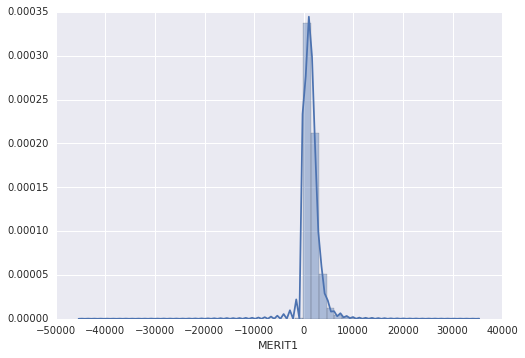

In [42]:
sns.distplot(empl1[empl1.MERIT1.notnull()].MERIT1)

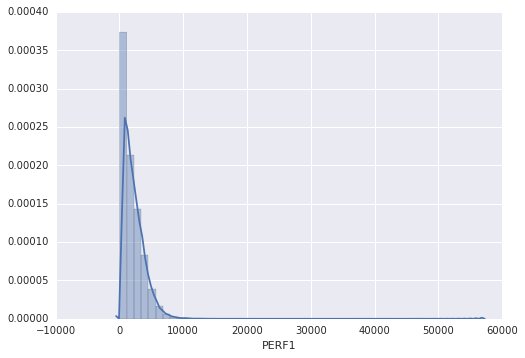

In [43]:
sns.distplot(empl1[empl1.PERF1.notnull()].PERF1)

In [44]:
empl1[['MERIT1','PERF1']].describe()

,MERIT1,PERF1
count,119146.000000,119146.000000
mean,1484.156075,1852.501799
std,1981.576853,1811.616211
min,-45000.000000,0.000000
25%,482.752500,471.302500
50%,1283.330000,1444.500000
75%,2132.705000,2784.275000
max,35000.000000,56751.140000


In [45]:
empl1[['MERIT1','PERF1']].median()

MERIT1    1283.33
PERF1     1444.50
dtype: float64

In [52]:
np.percentile(empl1[empl1.MERIT1.notnull()].MERIT1.values,0.05)

-23048.2552

In [51]:
np.percentile(empl1[empl1.PERF1.notnull()].PERF1.values,0.02)

0.0

### 4. Now deal with the categorical ones
* dummy_encode 7;
* label_encode 3: GRADE, JOB_FAMILY, LOC_STATE


In [53]:
cat_cols_to_dummy

['EMPL_TYPE',
 'FULL_PART_TIME',
 'SHIFT',
 'EMPL_CLASS',
 'EEO1CODE',
 'JOB_FUNCTION',
 'loc_desc']

### Add a few categorical columns that already have Integer values:
* COMPANY
* DIVISION_CODE_SFI

In [54]:
[(a,empl1[a].nunique()) for a in empl1.columns.tolist() if a.endswith('SFI')] # these are technically more categorical

[('DIVISION_CODE_SFI', 9),
 ('EXT_FUNC_ID_SFI', 336),
 ('FLOR_SFI', 108),
 ('FUNC_ID_SFI', 53),
 ('LOC_TYPE_DESCR_SFI', 31),
 ('RELOCATE_ALL_SFI', 2),
 ('RELO_STATE_CNT_SFI', 55)]

In [55]:
cat_cols_to_dummy.append('COMPANY')
cat_cols_to_dummy.append('DIVISION_CODE_SFI')

In [56]:
my_label_encode_cols = ['GRADE','JOB_FAMILY','LOC_STATE']

### 5. Drop some columns

In [72]:
all_cols = empl1.columns.tolist()
model_cols = [c for c in all_cols if not c in cat_cols_to_ignore]
model_cols = [c for c in model_cols if not c in cat_cols_to_drop]
len(model_cols), len(all_cols)

(119, 128)

In [73]:

#cate_list = br.get_categorical(X)
# need to break the categorical into types
pipe = Pipeline([("null", br.RemoveAllNull()),  
                 ("label_encode",br.LabelEncodeColumn(my_label_encode_cols)),
                 ("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy)),
                 #("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 #("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],
                                                    criteria_coef=('percentile',2),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',2),
                                                   method='both',fill_with='nearest_value')),
                 #("fill_missingzero",FillMissingValue(columns_to_fix=['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT'],fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=missing_cols,rows_to_scan=0.8))])
                 #("imp_mean", br.ImputeData(columns_to_impute='auto', rows_to_scan=0.8))])
                 #("redu", br.DimensionReduction(rows_to_scan=0.3, n_components=10))])
#pipe.fit(X, y).transform(testX)[0:30]
#
#Xft = pipe.fit_transform(X)

# Focus on Separation
* eliminate those that were retired or are over 55.
* create a test train split on this set
* create and apply pipeline
* remove redudant variables
* build survival model

In [74]:
nr_em = empl1[(empl1.retired ==0)&(empl1.Age_years <=55)].copy()
print (len(nr_em))

105235


### remove some of the historical columns

In [76]:
historical_cols10 = [col for col in all_cols if col.endswith('10')]
mos_cols = [col for col in all_cols if col.endswith('MOS')]
print( historical_cols10)

print(mos_cols)

['ADDRCNT10', 'DEPTCNT10', 'EFUNCCNT10', 'FLOORCNT10', 'FTPTCNT10', 'FULLPART10', 'FUNCCNT10', 'GRADECNT10', 'JOBCNT10', 'LOCCNT10', 'LOCSTCNT10', 'PARTFULL10', 'PTFTCNT10', 'SUPVCNT10']
['CUR_DEPT_MOS', 'CUR_EFUNC_MOS', 'CUR_FUNC_MOS', 'CUR_GRADE_MOS', 'CUR_JOB_MOS', 'CUR_LOC_MOS', 'TELE_MOS']


In [77]:
historical_cols5 = [col for col in all_cols if col.endswith('5')]#[:-3]
historical_cols3 =[col for col in all_cols if col.endswith('3')]#[:-4]
len(historical_cols3), len(historical_cols5),len(historical_cols10), len(mos_cols)

(14, 14, 14, 7)

In [78]:
historical_cols = []
historical_cols+=historical_cols3
historical_cols+=historical_cols5
historical_cols+=historical_cols10
print len(historical_cols)

42


### remove the time_stamp columns

In [80]:
sep_model_cols = [col for col in nr_em.columns.tolist() if not col.endswith('tstmp')]
sep_model_cols = [col for col in sep_model_cols if not col in historical_cols]
print(len(nr_em.columns.tolist()),len(sep_model_cols))

(128, 83)


In [82]:
pd.crosstab(nr_em.status,nr_em.terminated)

terminated,0,1
status,,
0,57091,0
1,0,48144


In [83]:
## remove mos columns
sep_model_cols = [col for col in sep_model_cols if not col in mos_cols]
sep_model_cols = [col for col in sep_model_cols if not col.endswith('tdelta')]
sep_model_cols.remove('retired')
sep_model_cols.remove('sep_status')
sep_model_cols.remove('status') # equivalent to terminated
sep_model_cols.remove('ANNUAL_RT') # equivalent to SAL1

## remove dates

In [92]:
sep_model_cols = [col for col in sep_model_cols if not col.endswith('DT')]
sep_model_cols.remove('BIRTHDATE')
print(len(sep_model_cols))

65


In [99]:
sep_model_cols.remove('LOC_TYPE_DESCR_SFI')

In [124]:
sep_model_cols.remove('KEY')

## create split

In [100]:
# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(nr_em))
eval_fraction = 0.20
nr2build, nr2eval = cross_validation.train_test_split(nr_em,test_size=eval_fraction,random_state = 77843)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(nr2eval),len(nr2build))

Starting with subset of 105235 employees.
Evaluation set has 21047 employees; training set has 84188 employees.


In [125]:
nr2b = pipe.fit_transform(nr2build[sep_model_cols])
nr2e = pipe.fit(nr2build[sep_model_cols]).transform(nr2eval)

In [126]:
print(len(nr2b.columns.tolist()))

126


In [103]:
br.perfect_collinearity_test(nr2b)

ADDRCNT1            VIF = 2.5   R^2 = 0.5964    
Age_years           VIF = 40.2  R^2 = 0.9751    
BOX1                VIF = 4.8   R^2 = 0.7908    
COMP_FREQUENCY      VIF = 36.3  R^2 = 0.9725    
DEPTCNT1            VIF = 3.2   R^2 = 0.6897    
DIRECT_RPT_CNT      VIF = 2.4   R^2 = 0.5918    
EFUNCCNT1           VIF = 1.7   R^2 = 0.4015    
ETHNIC_GROUP        VIF = 1.1   R^2 = 0.1271    
EXTFUNC_CNT         VIF = 3.5   R^2 = 0.7137    
EXT_FUNC_ID_SFI     VIF = 2.6   R^2 = 0.6219    
FLOORCNT1           VIF = 1.9   R^2 = 0.4754    
FLOR_SFI            VIF = 1.9   R^2 = 0.4646    
FLSA_STATUS         VIF = 188.8 R^2 = 0.9947    
FTE                 VIF = 5054.0R^2 = 0.9998    
FTPTCNT1            VIF = 1.7   R^2 = 0.4272    
FULLPART1           VIF = 1.7   R^2 = 0.4272    
FUNCCNT1            VIF = 2.1   R^2 = 0.5136    
FUNC_CNT            VIF = 6.3   R^2 = 0.8405    
FUNC_ID_SFI         VIF = 1.7   R^2 = 0.4015    
GRADECNT1           VIF = 2.7   R^2 = 0.6244    
HUBIND              

ADDRCNT1               0.596446
Age_years              0.975111
BOX1                   0.790776
COMP_FREQUENCY         0.972461
DEPTCNT1               0.689732
DIRECT_RPT_CNT         0.591828
EFUNCCNT1              0.401459
ETHNIC_GROUP           0.127124
EXTFUNC_CNT            0.713664
EXT_FUNC_ID_SFI        0.621882
FLOORCNT1              0.475357
FLOR_SFI               0.464642
FLSA_STATUS            0.994703
FTE                    0.999802
FTPTCNT1               0.427201
FULLPART1              0.427201
FUNCCNT1               0.513578
FUNC_CNT               0.840547
FUNC_ID_SFI            0.401474
GRADECNT1              0.624351
HUBIND                 0.450140
INTERN                 0.561678
JOBCNT1                0.688775
JOBCODE                0.779648
KEY                    0.226141
LOCCNT1                0.225839
LOCSTCNT1              0.440253
MAX_RT_ANNUAL          0.994962
MERIT1                 0.565335
MIN_RT_ANNUAL          0.992857
                         ...   
loc_desc

In [104]:
nr2b[['loc_desc_TELE','REMOTE']].corr()

,loc_desc_TELE,REMOTE
loc_desc_TELE,1,1
REMOTE,1,1


In [127]:
#redundant_cols = ['ANNUAL_RT','hire_age','loc_desc_TELE','status','sep_status','PERF1_d']
redundant_cols = ['hire_age','loc_desc_TELE','HUBIND','PERF1_d']
model_cols2 = nr2b.columns.tolist()
sep_model_cols2 = [c for c in model_cols2 if not c in redundant_cols]
print(len(model_cols2),len(sep_model_cols2))


(126, 122)


## just do a RF classifier of terminated on the training set to see driving features

In [128]:
rfclass_cols = [col for col in sep_model_cols2 if 'terminated' not in col]
print(len(rfclass_cols))


121


In [129]:
%%time
# Fit classification model
params = {'n_estimators': 300, 'n_jobs': -1, 'oob_score': True}
          #'max_depth': 4, 'min_samples_split': 1,
          #'learning_rate': 0.01, 'loss': 'ls','n_jobs': -1}
fullRFC = ensemble.RandomForestClassifier(**params)

fullRFC.fit(nr2b[rfclass_cols], nr2b.terminated)

CPU times: user 2min 32s, sys: 733 ms, total: 2min 32s
Wall time: 16.1 s


## apply this to the evaluation set

In [130]:
rfclass_pred = fullRFC.predict(nr2e[rfclass_cols])


In [113]:

def plot_conf_matrix(y_true,y_pred,normed=True,**kwargs):
    my_c = metrics.confusion_matrix(y_true,y_pred)
    
    print metrics.matthews_corrcoef(y_true,y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')
        
    sns.heatmap(my_c, annot=True,  fmt='',cmap='Blues')
    plt.ylabel('True')
    #plt.yticks
    plt.xlabel('Assigned')
    plt.show()
    
    return

def plot_roc_curve(target_test, target_predicted_proba, **kwargs):
    fpr, tpr, thresholds = metrics.roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = metrics.auc(fpr, tpr)
    # Plot ROC curve
    label_txt = 'ROC curve (area = %0.3f)' % roc_auc
    plt.plot(fpr, tpr, label=label_txt,**kwargs)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    return roc_auc

0.973099745029


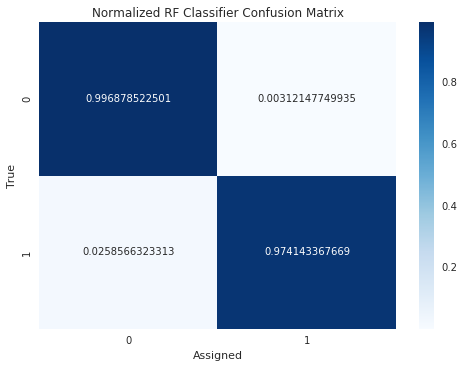

In [131]:
plot_conf_matrix(nr2e.terminated,rfclass_pred)

In [132]:
metrics.accuracy_score(nr2e.terminated,rfclass_pred)

0.98660141587874761

### look at the feature_importances

In [119]:
# function to push feature_importances for a set of RF models into a dataframe
def create_fi_df(mdl_list,feature_names):
    list_feature_importances = []
    col_list = []
    for i,mdl in enumerate(mdl_list):
        list_feature_importances.append(plotFI(mdl,feature_names,show_plot=False))
        col_list.append('fold'+str(i)+'_value')
        col_list.append('fold'+str(i)+'_std')

    fi_df = pd.concat(list_feature_importances,axis=1)
    # create column headings
    fi_df.columns = col_list
    # create the average of the values
    value_cols = [x for x in col_list if x.endswith('value')]
    
    fi_df['avg_val']=fi_df[value_cols].mean(axis=1)
    fi_df['avg_variance']=fi_df[value_cols].std(axis=1)
#t2_eval_fi_df[['avg_val','avg_std']].sort('avg_val',ascending=False)
    return fi_df

def plotFI(forest,featureNames=[],show_plot=True):#,autoscale=True,headroom=0.05):
    """
    forest is the model to be graphed.
    featureNames is the list of features to be displayed
    
    """
    #if autoscale:
    #    x_scale = forest.feature_importances_.max()+ headroom
    #else:
    #    x_scale = 1
    
    featureImportances=forest.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    estimators = forest.estimators_
    # calculate the variance over the forest 
    
    std = np.std([tree.feature_importances_ for tree in estimators],axis=0)
    # print summary statement
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    print("Number of Trees: %d" %(len(estimators)))
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    if show_plot:
        plt.title("Feature importances")
        plt.barh(range(len(kindices)), featureImportances[kindices],
           color="steelblue", xerr=std[kindices], align="center",ecolor='k')#,lw=2)
    
        plt.yticks(range(len(kindices)),fN2)
        #grid(True)
    
    c1 = 'value'
    c2 = 'std'
    tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = tdata.T,index=fN2,columns=[c1,c2])
    return df

Number of Features: 121
Number of Trees: 300
Feature ranking:
1. feature 17=FUNC_CNT (0.145979)
2. feature 43=HAVE_INS (0.112280)
3. feature 27=MIN_RT_ANNUAL (0.074897)
4. feature 8=EXTFUNC_CNT (0.061092)
5. feature 9=EXT_FUNC_ID_SFI (0.056075)
6. feature 29=PERF1 (0.047626)
7. feature 25=MAX_RT_ANNUAL (0.044239)
8. feature 44=HAVE_DEP (0.031708)
9. feature 45=DEP_COUNT (0.030105)
10. feature 26=MERIT1 (0.029210)
11. feature 42=Tenure_years (0.027584)
12. feature 36=SAL1 (0.024562)
13. feature 2=BOX1 (0.021991)
14. feature 18=FUNC_ID_SFI (0.020152)
15. feature 6=EFUNCCNT1 (0.017564)
16. feature 0=ADDRCNT1 (0.017440)
17. feature 4=DEPTCNT1 (0.015919)
18. feature 22=JOBCODE (0.015757)
19. feature 48=GRADE_le (0.014912)
20. feature 49=JOB_FAMILY_le (0.014571)
21. feature 21=JOBCNT1 (0.013893)
22. feature 112=DIVISION_CODE_SFI_9 (0.013553)
23. feature 39=SUPVCNT1 (0.013128)
24. feature 1=Age_years (0.011182)
25. feature 5=DIRECT_RPT_CNT (0.009713)
26. feature 41=TOTAL_RPT_CNT (0.008536)
27

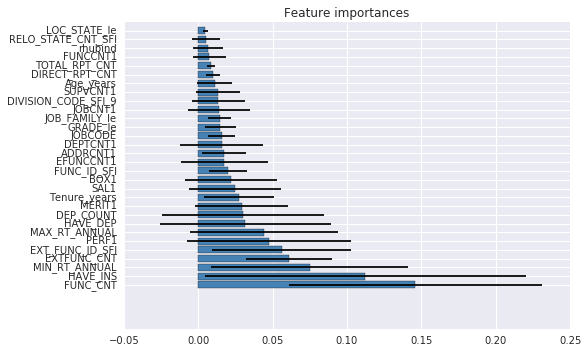

In [134]:
rfc_df = plotFI(fullRFC,rfclass_cols)

In [138]:
ordered_features = rfc_df.index.tolist()
ordered_features.remove('Tenure_years')

In [139]:
rfc_df[rfc_df.value>0.001]

,value,std
FUNC_CNT,0.145979,0.085134
HAVE_INS,0.112280,0.108025
MIN_RT_ANNUAL,0.074897,0.066197
EXTFUNC_CNT,0.061092,0.028677
EXT_FUNC_ID_SFI,0.056075,0.046833
PERF1,0.047626,0.055301
MAX_RT_ANNUAL,0.044239,0.049453
HAVE_DEP,0.031708,0.057517
DEP_COUNT,0.030105,0.054629
MERIT1,0.029210,0.031148


In [140]:
#from ll.fitters import CoxPHFitter
cf1 = ll.CoxPHFitter(penalizer=1.0)

In [142]:
tmp_features = ordered_features[:29]
tmp_features.append('Tenure_years')
tmp_features.append('terminated')

In [143]:
%%time
cf1_5fold_scores = ll.utils.k_fold_cross_validation(cf1,nr2b[tmp_features],'Tenure_years',event_col='terminated',k=5)

/opt/anaconda/2.3.0/lib/python2.7/site-packages/lifelines/utils/__init__.py:468: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.reindex(np.random.permutation(df.index)).sort(event_col)
/opt/anaconda/2.3.0/lib/python2.7/site-packages/lifelines/utils/__init__.py:473: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  testing_columns = df.columns - [duration_col, event_col]
/opt/anaconda/2.3.0/lib/python2.7/site-packages/lifelines/fitters/coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


CPU times: user 4min 45s, sys: 2min 51s, total: 7min 37s
Wall time: 3min 47s


In [144]:
cf1_5fold_scores

[0.87936068211537988,
 0.87993339664188663,
 0.877279531187522,
 0.88066755118139339,
 0.87777519896878142]

In [145]:
cf1.print_summary()

n=67351, number of events=30904

                          coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
FUNC_CNT            -1.919e-01  8.254e-01 1.295e-02 -1.481e+01  1.173e-49  -2.173e-01  -1.665e-01  ***
HAVE_INS            -2.045e-01  8.151e-01 9.608e-03 -2.128e+01 1.672e-100  -2.233e-01  -1.856e-01  ***
MIN_RT_ANNUAL       -7.810e-01  4.579e-01 2.404e-02 -3.248e+01 1.945e-231  -8.281e-01  -7.339e-01  ***
EXTFUNC_CNT          5.024e-02  1.052e+00 6.327e-03  7.941e+00  1.998e-15   3.784e-02   6.265e-02  ***
EXT_FUNC_ID_SFI     -9.130e-02  9.127e-01 9.718e-03 -9.395e+00  5.712e-21  -1.104e-01  -7.225e-02  ***
PERF1               -9.948e-02  9.053e-01 1.237e-02 -8.042e+00  8.809e-16  -1.237e-01  -7.523e-02  ***
MAX_RT_ANNUAL        5.116e-01  1.668e+00 1.985e-02  2.577e+01 1.770e-146   4.727e-01   5.506e-01  ***
HAVE_DEP            -2.274e-01  7.966e-01 1.734e-02 -1.312e+01  2.623e-39  -2.614e-01  -1.935e-01  ***
DEP_COUNT            1.429e-02  1.014e+0

## looking at this list 
* remove DEP_COUNT, FUNC_ID_SFI, ADDRCNT1


In [148]:
second_try_cols = [col for col in tmp_features if not col in ['DEP_COUNT','FUNC_ID_SFI','ADDRCNT1']]
print(len(second_try_cols))
added_cols = ['JOB_FUNCTION_PSA','SEX','FLSA_STATUS','INTERN']
for col in added_cols:
    second_try_cols.append(col)
print(len(second_try_cols))

28
32


In [149]:
%%time
cf2 = ll.CoxPHFitter(penalizer=1.0)
cf2_5fold_scores = ll.utils.k_fold_cross_validation(cf2,nr2b[second_try_cols],'Tenure_years',event_col='terminated',k=5)

CPU times: user 4min 58s, sys: 2min 19s, total: 7min 17s
Wall time: 3min 47s


In [150]:
cf2_5fold_scores

[0.88101578614000375,
 0.8810755082100622,
 0.88322909853935039,
 0.88069833990937663,
 0.8819151249554158]

In [151]:
cf2.print_summary()

n=67351, number of events=30904

                          coef  exp(coef)  se(coef)          z          p  lower 0.95  upper 0.95     
FUNC_CNT            -1.999e-01  8.188e-01 1.265e-02 -1.580e+01  2.916e-56  -2.247e-01  -1.751e-01  ***
HAVE_INS            -1.910e-01  8.262e-01 9.642e-03 -1.980e+01  2.698e-87  -2.099e-01  -1.721e-01  ***
MIN_RT_ANNUAL       -8.648e-01  4.211e-01 2.392e-02 -3.616e+01 2.642e-286  -9.117e-01  -8.179e-01  ***
EXTFUNC_CNT          6.088e-02  1.063e+00 6.199e-03  9.822e+00  9.095e-23   4.873e-02   7.303e-02  ***
EXT_FUNC_ID_SFI     -6.936e-02  9.330e-01 9.191e-03 -7.546e+00  4.485e-14  -8.738e-02  -5.134e-02  ***
PERF1               -6.850e-02  9.338e-01 1.222e-02 -5.607e+00  2.054e-08  -9.244e-02  -4.455e-02  ***
MAX_RT_ANNUAL        4.308e-01  1.538e+00 2.090e-02  2.061e+01  2.106e-94   3.898e-01   4.718e-01  ***
HAVE_DEP            -2.252e-01  7.984e-01 1.175e-02 -1.916e+01  7.516e-82  -2.482e-01  -2.022e-01  ***
MERIT1               3.180e-01  1.374e+0

## Explore the difference between RETIRE & SEPARATION

In [ ]:
em1[['retired','terminated']].corr()

In [ ]:
pd.crosstab(em1['retired'],em1['terminated'])

In [ ]:
pd.crosstab(em1['status'],em1['terminated'])

In [ ]:
sum(em1['Age_years']>=50.0)

In [ ]:
over50 = em1[em1['Age_years']>=50.].copy()

In [ ]:
sns.distplot(em1[em1.Age_years<50.]['Tenure_years'],label='under50')
sns.distplot(em1[em1.Age_years>=50.]['Tenure_years'],label='over50')
plt.legend()

In [ ]:
over50.retired.value_counts()

In [ ]:
over50.status.value_counts()

In [ ]:
over50.terminated.value_counts()

## what about removing retired from list of training/test set for my model?

In [ ]:
nr_em.status.value_counts(), nr_em.terminated.value_counts()

In [ ]:
pd.crosstab(nr_em.status,nr_em.terminated)

### create a hold out set

In [ ]:
# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(nr_em))
eval_fraction = 0.20
ne2build, ne2eval = cross_validation.train_test_split(nr_em,test_size=eval_fraction,random_state = 77843)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(ne2eval),len(ne2build))

In [ ]:
ne2build.status.value_counts()

In [ ]:
ne2eval.status.value_counts()

In [ ]:
len(mod_cols2)

In [ ]:
simple_drop_cols =['retired','terminated']
sep_mod_cols = [col for col in mod_cols2 if not col in simple_drop_cols]


In [ ]:
sep_mod_cols.append('status')
len(sep_mod_cols)

## Look at Tenure distribution (again)

In [ ]:
sns.distplot(ne2build.Tenure_years,label='build set')
sns.distplot(ne2eval.Tenure_years,label='eval set')
plt.legend()

### Check that they are statistically similar

In [ ]:
from scipy import stats  
  
z_stat, p_val = stats.ranksums(ne2build.Tenure_years, ne2eval.Tenure_years)  
  
print "MWW RankSum P for ne2 build and eval sets Tenure years=", p_val  
print "MWW RankSum Z-state for ne2 build and eval sets Tenure years=", z_stat  

## Do an overall regressor of Tenure_years 
* this establishes a benchmark on accuracy
* methods:
    - RF
    - GBM
    - linear

In [ ]:
### define the columns to use
'status' in sep_mod_cols[:-1]
regress_cols = [cols for cols in sep_mod_cols if cols != 'Tenure_years']
regress_cols.remove('status')


In [ ]:
%%time
# Fit regression model
params = {'n_estimators': 300, 'n_jobs': -1, 'oob_score': True}
          #'max_depth': 4, 'min_samples_split': 1,
          #'learning_rate': 0.01, 'loss': 'ls','n_jobs': -1}
fullRFR = ensemble.RandomForestRegressor(**params)

fullRFR.fit(ne2build[regress_cols], ne2build.Tenure_years)

In [ ]:
## apply to the eval set for MSE

rfr_tenure_pred = fullRFR.predict(ne2eval[regress_cols])
mse = metrics.mean_squared_error(ne2eval.Tenure_years,rfr_tenure_pred )
print("MSE: %.4f" % mse)

In [ ]:
plt.scatter(ne2eval.Tenure_years,rfr_tenure_pred,alpha=0.3)
plt.xlabel('True Tenure')
plt.ylabel('Predicted Tenure')

In [ ]:
plt.scatter(ne2eval[ne2eval.status==1].Tenure_years, fullRFR.predict(ne2eval[ne2eval.status==1][regress_cols]),alpha=0.3,color='indianred')
plt.xlabel('True Tenure Years')
plt.ylabel('Predicted Tenure years')
plt.title('For those who separated (evaluation set)')
mse = metrics.mean_squared_error(ne2eval[ne2eval.status==1].Tenure_years, fullRFR.predict(ne2eval[ne2eval.status==1][regress_cols] ))
print("MSE: %.4f" % mse)

In [ ]:
rf_full_regresssion_tenure = plotFI(fullRFR,ne2build[regress_cols].columns.tolist())

#### It looks like the time-sensitive fields (i.e. those ending in '10' or MOS are the dominating ones here)

In [ ]:
sns.distplot(ne2build['CUR_FUNC_MOS'],label='current_func_mos')
sns.distplot(ne2build['CUR_LOC_MOS'],label='current_loc_mos')
sns.distplot(ne2build['CUR_GRADE_MOS'],label='current_grade_mos')
plt.legend()
plt.xlabel('months of service value')

In [ ]:
sns.distplot(ne2build['ADDRCNT10'],label='addresscount10')
sns.distplot(ne2build['JOBCNT10'],label='jobcount10')
sns.distplot(ne2build['ADDRCNT1'],label='addresscount1')
sns.distplot(ne2build['JOBCNT1'],label='jobcount1')
plt.legend()


In [ ]:
regress_cols2 = [col for col in regress_cols if not col in historical_cols]

In [ ]:
%%time
# Fit regression model
params = {'n_estimators': 300, 'n_jobs': -1, 'oob_score': True}
          #'max_depth': 4, 'min_samples_split': 1,
          #'learning_rate': 0.01, 'loss': 'ls','n_jobs': -1}
fullRFR2 = ensemble.RandomForestRegressor(**params)

fullRFR2.fit(ne2build[regress_cols2], ne2build.Tenure_years)

In [ ]:
## apply to the eval set for MSE

rfr2_tenure_pred = fullRFR2.predict(ne2eval[regress_cols2])
mse = metrics.mean_squared_error(ne2eval.Tenure_years,rfr2_tenure_pred )
print("MSE: %.4f" % mse)

plt.scatter(ne2eval.Tenure_years,rfr2_tenure_pred,alpha=0.3)
plt.xlabel('True Tenure (years)')
plt.ylabel('Predicted Tenure (years)')

plt.title('Evaluation set RFR2')

In [ ]:
rf2_full_regresssion_tenure = plotFI(fullRFR2,regress_cols2)

In [ ]:
for mcol in mos_cols[:-1]:
    sns.distplot(ne2build[mcol],label=mcol)
plt.legend()

# Construct the time k-folds
### use the novel temporal kfolds
1. for the training set split into time-windows 
2. for the evaluation set reset the index and apply time-windows

In [ ]:
# define the date range
full_date_range = [str(a)+'-01-01' for a in np.arange(2002,2016)]
print len(full_date_range)

In [ ]:
tstmp_cols = [col for col in ne2build.columns.tolist() if col.endswith('tstmp')]

In [ ]:
import itertools
def create_temporal_kfolds(dates_df,date_range,time_delta):
    """
    inputs: date_range
            time_delta (in years)
            dataframe_dates --> assumes 'hire_tstmp' and 'term_tstmp'
    outputs:
            kf is a list of list of list: 
            [indices from original df that are 'in' a fold, indices from original df that are 'out' of a fold]
            each row in this corresponds to the temporal-kfold
            filtered_pairs is a list of start and end times
    """
    min_date = pd.to_datetime(date_range[0])
    max_date = pd.to_datetime(date_range[-1])
    my_index = dates_df[(dates_df.term_tstmp>=min_date)].index
    # calculate number of kfolds
    date_span_years = np.int(np.round((max_date-min_date).days/365.24,0))
    nfolds = date_span_years - time_delta
    print date_span_years, time_delta, nfolds, len(my_index)
    all_pairs = list(itertools.combinations(date_range,2))
    # now filter if difference in time  == time_delta
    filtered_pairs = []
    for i0,i1 in all_pairs:
        if int(i1[:4])-int(i0[:4]) == time_delta:
            filtered_pairs.append([i0,i1])
            #print i0,i1
    print len(filtered_pairs)
    # now process each of these filtered pairs
    kf = []
    for j0,j1 in filtered_pairs: # omit the last one because it has no corresponding partner/endtime
        start_date = pd.to_datetime(j0)
        end_date = pd.to_datetime(j1)
        #print j0,j1#,len(k)
        
        
        kfold_idx = dates_df[(dates_df.term_tstmp >= start_date) & (dates_df.hire_tstmp<start_date)].index.tolist()
        after_idx = dates_df[(dates_df.hire_tstmp>=end_date)].index.tolist()
        before_idx = list(set(my_index)-set(kfold_idx)-set(after_idx))
        #temporal_kfold(dates_df[dates_df.term_tstmp>=min_date],start_date,end_date)
        #print "\t",len(kfold_idx), len(after_idx),len(before_idx)
        
        # combined out of fold
        not_kfold_idx = list(set(after_idx).union(set(before_idx)))
        
        print j0,j1,len(kfold_idx),len(not_kfold_idx)
        kf.append([kfold_idx,not_kfold_idx])
    
    return kf,filtered_pairs

In [ ]:
def reset_years2(paired_times,indices,dates_df,cols_to_alter = ['Age_years','Tenure_years']):
    # calc the Age at beginnning of time period
    ## now calculate age at hire
    reset_age_tdelta = pd.to_datetime(paired_times[0])-dates_df['birth_tstmp']#)/np.timedelta64(1,'D')
    reset_tenure_tdelta = pd.to_datetime(paired_times[0])-dates_df['hire_tstmp']#)/np.timedelta64(1,'D')
    # convert to days, months or years
    reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
    reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
    # look at terminated or not
    #empl_df['terminated']= 0
    # push these as a data frame so I can merge
    adj_times = pd.DataFrame()
    adj_times['adj_age']=reset_age
    adj_times['adj_tenure']=reset_tenure      
    return adj_times


In [ ]:
def define_target_within_x_years(df,paired_dates,tfold,n_years,target_col):
    """
    inputs:
        df -- data frame
        paired_dates (2nd output from create_temporal_kfolds)
        tfold (1st output from create_temporal_kfolds)
        targe_col --> desired target
        
    plan is to adjust the target, Age and tenure to match time frame of temporal kfold
    outputs:
    """
    print len(tfold)#, paired_dates

    df_dict = {}
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        #print start_date,end_date,n_years
        #altered_fold_df = pd.DataFrame(columns=['fold_mbr','adj_age','adj_tenure','adj_term'])
        # if in the fold reset the age to start of fold; define new window of termination
        in_fold_idx = tfold[i][0] # the index of the in_fold_observations 
        # note that "sex" is just used to create a value that then gets dummied out
        cols_to_copy = ['SEX','Age_years','Tenure_years']
        cols_to_copy.append(target_col)
        
        altered_fold_df = df[cols_to_copy].copy()
        # adjust these
        altered_fold_df.columns=['fold_mbr','adj_age','adj_tenure','adj_tgt']
        altered_fold_df.fold_mbr = 0
        
        #ra,rt = reset_years(paired_dates[i],in_fold_idx,dates_df)
        adj_df =reset_years2(paired_dates[i],in_fold_idx,df)
        #altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        #altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        altered_fold_df.loc[in_fold_idx,['adj_age','adj_tenure']]=adj_df.ix[in_fold_idx] # assign to the altered values
        new_tgt = (df.ix[in_fold_idx]['term_tstmp']<= end_date).as_matrix().astype(np.int)
        #(em2mod.ix[kf[0][0]]['term_tstmp']<= fp[0][1]).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_tgt = (df.ix[in_fold_idx]['term_tstmp']< end_date).as_matrix().astype(np.int)
        #print "\t", len(new_term),sum(new_term)
        altered_fold_df.loc[in_fold_idx,'adj_tgt']=new_tgt
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel

In [ ]:
def setup_tfolds(df, n_years, cols_to_model, tgt_value='status',
                 time_cols=['Age_years','Tenure_years'], tstmp_cols = tstmp_cols, date_range=full_date_range):
    """ Function to create the temporal kfolds
    parameters:
        df       - a pandas data frame (that has been preprocessed)
        n_years  - size of the temporal window (in years)
        cols_to_model - list of columns to use in the modeling procedure 
        tgt_value  - column name to use as the target variable
        time_cols  - list of columns that are time senitive and must be adjusted
        tstmp_cols - list of columns that contain timestamps for things like hiring, termination and birth
        date_range - list comprising the inclusive annual starting dates from beginning to end of range.
    output:
        tfolds  - a list containing the indices of in and out of fold members for each of the tfolds created
        tfold_panel - a pandas Panel (3D data frame) containing the membership in different folds, the adjusted targets,
            the adjusted timesenitive data, and the columns to use for modeling.
    """    
    # step 1 create the temporal_folds
    if not [a for a in tstmp_cols if a in df.columns] == tstmp_cols:
        print "The list of required timestamp columns do not exist in the input dataframe."
        print tstmp_cols
        exit
    tfolds, paired_dates = create_temporal_kfolds(df[tstmp_cols],date_range, n_years) 
    #defines the time-windows and assigns observations to folds
    
    # create the time-shifted tfolds and push into a pandas Panel (3D data frame)
    tfold_panel=transform_df_to_tfold(df,tfolds,paired_dates,n_years,cols_to_model, tgt_value,tstmp_cols,time_cols)
    return tfold_panel, tfolds

In [ ]:
def transform_df_to_tfold(df,tfold,paired_dates,n_years,cols_to_keep,target_col,tstmp_cols,time_cols):
    """
    Function to adjust the input data frame so that time_sensitive columns and target column
    conform to the bounds of that temporal kfold (tfold). Specifically adjust the target, Age and tenure 
    to match time frame of temporal kfold
    
    Parameters:
        df -- a pandas data frame
        paired_dates (2nd output from create_temporal_kfolds)
        tfolds (1st output from create_temporal_kfolds)
        target_col --> desired target
        cols_to_keep --> the list of columns within df that get expressed in df.
        time_cols
        
    plan is to 
    outputs:
        tfold_panel
    """
    #print len(tfold)#, paired_dates
    #print df.columns ,len(df.columns), len(cols_to_keep)
    #return
    # do some sanity checks
    # 1. make sure cols_to_keep, target and tstmp_cols columns are in df.columns
    input_column_list = df.columns.tolist()
    n_total_columns = len(input_column_list)
    #if (n_total_columns != len(cols_to_keep)+len(target_col)+len(tstmp_cols)):
        # now look at each piece
    targetlist = []
    targetlist.append(target_col)
    if not check_if_subset(targetlist,input_column_list):
            #target_col in df.columns:
            #print "{0} target column not present in input set".format(target_col)
        return
    if not check_if_subset(tstmp_cols,input_column_list):
        return
            #[a for a in tstmp_cols if a in input_column_list] == tstmp_cols: # requires
            #print "There are missing timestamp columns. Recheck the list {0}".format(tstmp_cols)
    #        return
    if not check_if_subset(time_cols,input_column_list):
            #[a for a in time_cols if a in input_column_list] == time_cols: # requires
            #print "There are missing timestamp columns. Recheck the list {0}".format(tstmp_cols)
        return    
    if not check_if_subset(cols_to_keep,input_column_list):
        return
    
    ## now set up the columns for manipulation
    cols_to_copy = cols_to_keep
    if not check_if_subset(time_cols,cols_to_keep):
        cols_to_copy+=time_cols
        print len(cols_to_copy)
    
    
    df_dict = {}
    
    # identify which element of tstmp_cols corresponds to term_tstmp
    term_id = tstmp_cols.index('term_tstmp')
    birth_id = tstmp_cols.index('birth_tstmp')
    hire_id = tstmp_cols.index('hire_tstmp')
    #print term_id, tstmp_cols[term_id]
    
    for i,tf in enumerate(tfold):
        start_date = paired_dates[i][0]
        end_date = paired_dates[i][1]
        
        in_fold_idx = tfold[i][0] # the index of the in_fold_observations 
       
        altered_fold_df = df[cols_to_copy].copy()
        altered_fold_df['fold_mbr']=0 # create a new column to identify membership in that fold.
        altered_fold_df.loc[in_fold_idx,'fold_mbr']=1 # assign the in_fold_indices to that fold membership
        ####
        # adjust the age and tenure for those in the fold
        reset_age_tdelta = pd.to_datetime(start_date)-df.ix[in_fold_idx][tstmp_cols[birth_id]]
        reset_age = reset_age_tdelta/np.timedelta64(1,'Y')
        reset_tenure_tdelta = pd.to_datetime(start_date)-df.ix[in_fold_idx][tstmp_cols[hire_id]]
        reset_tenure = reset_tenure_tdelta/np.timedelta64(1,'Y')
        altered_fold_df.loc[in_fold_idx,'Age_years']=reset_age
        altered_fold_df.loc[in_fold_idx,'Tenure_years']=reset_tenure
        old_tgt = df.ix[tfold[i][1]][target_col]
        new_tgt = (df.ix[in_fold_idx][tstmp_cols[term_id]]<= end_date).as_matrix().astype(np.int)
        # deal with last time-fold specially
        if i == len(tfold)-1:
            new_tgt = (df.ix[in_fold_idx][tstmp_cols[term_id]]< end_date).as_matrix().astype(np.int)
            
        altered_fold_df.loc[in_fold_idx,target_col]=new_tgt
        old_tgt = df.ix[tfold[i][1]][target_col]
        altered_fold_df.loc[tfold[i][1],target_col] = old_tgt
        #ra,rt = reset_years(paired_dates[i],in_fold_idx,dates_df)
        """adj_df =reset_years2(paired_dates[i],in_fold_idx,df)
        #altered_fold_df.ix[in_fold_idx]['adj_age']=ra
        #altered_fold_df.ix[in_fold_idx]['adj_tenure']=rt
        altered_fold_df.loc[in_fold_idx,time_cols]=adj_df.ix[in_fold_idx] # assign to the altered values
        
        #(em2mod.ix[kf[0][0]]['term_tstmp']<= fp[0][1]).as_matrix().astype(np.int)
        
        #print "\t", len(new_term),sum(new_term)
        
        """
        
        df_dict[i]=altered_fold_df
    # now append this to a larger panel
    tfold_panel = pd.Panel.from_dict(data =df_dict)
    return tfold_panel
    

def check_if_subset(list1,list2): #compare_column_lists(list1,list2):
    if set(list1).issubset(set(list2)):
        return 1
    else:
        print "{0} is not contained in {1}. Recheck your lists.".format(list1,list2)
        return 0
    

In [ ]:
from sklearn import tree
def apply_tKfold_CV2(modeltype, in_panel, tkfolds, cols_to_use, tgt_column = 'status', ntrees=100,njobs=-1):
    """ Calculate the rmse for each cross-validated temporalFold
    
    Parameters:
        model - a scikit learn model name
        in_panel  - a pandas Panel with the observed input data adjusted 
        tgt_column -- the target variable
        cols_to_use -- the input variables to be used in modeling
        tkfolds -- the temporal timefolds (list of dimension 2)
    outputs:
        models --> the list of fit models
        RMSE --> the rmse error
        
    """
    RMSE = []
    roc_auc = []
    models = []
    
    
    
    for fold_id, indices in enumerate(tkfolds):
        training = indices[0]
        testing = indices[1]
        print "Running on fold number {0} containing {1} training and {2} test elements".format(fold_id, len(training),len(testing))
        X_train, X_test = in_panel[fold_id][cols_to_use].ix[training].as_matrix(), in_panel[fold_id][cols_to_use].ix[testing].as_matrix()
        y_train, y_test = in_panel[fold_id][tgt_column].ix[training].as_matrix(), in_panel[fold_id][tgt_column].ix[testing].as_matrix()
        print len(X_train),len(y_train)
                                                                                                
                                                                                                
        if modeltype == 'rfc':
            model = ensemble.RandomForestClassifier(n_estimators=ntrees, max_features='auto', oob_score=True,n_jobs=njobs)
        elif modeltype=='bgc':
            model=ensemble.GradientBoostingClassifier(n_estimators=ntrees,max_features='auto',learning_rate=0.01)
        else:
            model=tree.DecisionTreeClassifier()
            
        # Train the model
        model.fit(X_train,y_train)
        # use the model to predict output
        y_fitted = model.predict(X_test)
        RMSE.append(np.sqrt(metrics.mean_squared_error(y_test,y_fitted)))
        roc_auc.append(metrics.roc_auc_score(y_test,y_fitted))
        models.append(model)
    # leave the model fit to the entire dataset
    #model.fit(in_x,in_y)
    
    return RMSE,roc_auc,models
        

## Steps to apply the above protocol
1. reintroduced tstmp cols (already there)
2. generate the assignment to the Temporal Fold and collapse into a panel
    * setup_tfolds
3. build the model and calculate RMSE +  roc_auc
    * apply_tkfold_CV2
4. evaluate on the hold-out data.
    * evaluate_models
5. evaluate Separation rates for current employees

In [ ]:
window_size = [1,2,3,4,5]

In [ ]:
used_features = [c for c in regress_cols2 if not c.endswith('MOS')] # remove MOS because of issue with back-dating
# remove a few other ones:
used_features.remove('MERIT1_d')
used_features.append('Tenure_years')
#for col in tstmp_cols:
#    used_features.append(col)
    
used_features.append('status')

print len(used_features)

### 5 year

In [ ]:
panel5,tfold5 = setup_tfolds(ne2build, 5, used_features,tgt_value='status',
                            time_cols=['Age_years','Tenure_years'])

In [ ]:
tf_model_cols = [c for c in used_features if not c.endswith('tstmp')]
tf_model_cols.remove('status')


In [ ]:
panel5

In [ ]:
%%time
rmse5, roc_auc5, rfmdl5 = apply_tKfold_CV2('rfc',panel5, tfold5, cols_to_use=tf_model_cols,ntrees=300)

In [ ]:
np.mean(rmse5), np.mean(roc_auc5)

In [ ]:
def evaluate_models(model_list,Xeval):
    eval_pred_class = np.zeros((len(Xeval),len(model_list)))
    eval_pred_proba = np.zeros((len(Xeval),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(Xeval)
        eval_pred_class[:,i]=mdl.predict(Xeval)
        eval_pred_proba[:,:,i]=eval_proba
    #print np.shape(eval_prediction_proba3)
    return eval_pred_class, eval_pred_proba

In [ ]:
def adjust_eval_by_x_years(df,year_val,modeling_columns,tstmp_cols=tstmp_cols,target_col='status'):
    # construct
  
    ## set up method to assess the eval set
    print "There are {0} elements in the evaluation set".format(len(df))
   
    print "original target variable value counts:", df[target_col].value_counts()
    # restructure to deal with time_frame retirement (target variable)
    yr_cut_val = year_val+0.5
    # index of those that actually accomplish target within timeframe (allow 0.5 additional years)
    eval_within_time_target_index = df[(df[target_col]==1) & (df.Tenure_years <= yr_cut_val)].index
    # exclude indices that are active and have tenure less than this time
    eval_excluded_index = df[(df[target_col]==0) & (df.Tenure_years  <= yr_cut_val)].index
    
    # the rest become my not-terminated set
    eval_active_index = set(df.index) - set(eval_within_time_target_index) - set(eval_excluded_index)
    print len(eval_excluded_index),len(eval_within_time_target_index), len(eval_active_index)
    eval_idx_to_use =df.ix[set(df.index)-set(eval_excluded_index)].index
    #len(eval_idx_to_use)
    # reset the target to 0 for active
    eval_new_target = df[target_col].copy()
    eval_new_target.ix[eval_active_index] = 0
    print "new target variable value counts: "
    print eval_new_target.ix[eval_idx_to_use].value_counts()
    print "_____"
    y_eval = eval_new_target.ix[eval_idx_to_use].as_matrix().astype(np.int) # true values
    eval_adj_tenure = df.ix[eval_idx_to_use].Tenure_years.apply(lambda x: x-year_val if (x>float(year_val)) else 0).values
    print len(eval_adj_tenure), len(y_eval)
    # now adjust age by length of time; use hire_age if not in set to use.
    eval_adj_age = df.ix[eval_idx_to_use].Age_years.apply(lambda x: x-year_val)
    hire_age = (df.ix[eval_within_time_target_index]['birth_tstmp']-df.ix[eval_within_time_target_index]['hire_tstmp'])/np.timedelta64(1,'Y')#.days/days_in_year
    eval_adj_age.ix[eval_within_time_target_index] = hire_age #df.ix[eval_within_time_target_index]['birth_tstmp'#df_dates['hire_age']
    
    # construct the evaluation X matrix
    print "input matrix has {0} features".format(len(modeling_columns))
    Xeval = np.zeros((len(eval_idx_to_use),len(modeling_columns)))
    # drop 'Age_years' and Tenure_years from the list
    cols_to_use = []
    cols_to_use+=modeling_columns
    cols_to_use.remove('Age_years')
    cols_to_use.remove('Tenure_years')#.copy()
    """
    Xeval[:,:-2] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    # now put the adjusted tenure and ages into this matrix
    Xeval[:,-2] = eval_adj_age.values
    Xeval[:,-1]=eval_adj_tenure
    #print len(modeling_columns),np.shape(Xeval)
    """
    # this version matches the changed ording of columns
    Xeval[:,0]=eval_adj_age.values
    Xeval[:,1]=eval_adj_tenure
    Xeval[:,2:] = df.ix[eval_idx_to_use][cols_to_use].as_matrix().astype(np.float)
    return Xeval, y_eval

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(ne2eval,5,tf_model_cols)

In [ ]:
#gb_mdl5_pred_class, gb_mdl5_pred_proba = evaluate_models(gb_mdl5,X5eval)
pred_rf5_class, pred_rf5_proba = evaluate_models(rfmdl5,X5eval)

In [ ]:
plot_conf_matrix(y5eval,map(np.int,pred_rf5_class.mean(axis=1)))#gb_mdl5_pred_class.mean(axis=1)))

In [ ]:
#plot_conf_matrix(y5eval,map(np.int,gb_mdl5_pred_class.mean(axis=1)))
plot_roc_curve(y5eval,pred_rf5_proba[:,:,:].mean(axis=2))#gb_mdl5_pred_proba[:,:,:].mean(axis=2))

In [ ]:
### plot individual ROC curves
for a in xrange(0,len(rfmdl5)):
    plot_roc_curve(y5eval,pred_rf5_proba[:,:,a])

In [ ]:
np.shape(pred_rf5_class)

In [ ]:
plot_conf_matrix(y5eval,pred_rf5_class[:,8])#gb_mdl5_pred_class.mean(axis=1)))

In [ ]:
fi_5df = create_fi_df(rfmdl5,tf_model_cols)
val_cols = [a for a in fi_5df.columns if 'value' in a]
fi_5df[val_cols].T.boxplot()
plt.title('Feature Importances for 5year former')
plt.ylabel('Feature Importances in Tfolds')

In [ ]:
fi_5df.sort_values(by='avg_val',ascending=False)[val_cols].head(20).T.boxplot(rot=90)

## This model is not great
* perhaps overfit?

In [ ]:
len(tf_model_cols)

In [ ]:
[col for col in tf_model_cols if col.startswith('JOB_FUNCTION')]

In [ ]:
empl1.JOB_FUNCTION.value_counts()

## Try a different PIPE:
* include the survival encoding

In [ ]:
empl1.Tenure_years.min(), empl1.Tenure_years.max()

In [ ]:
ann_tenure_range = np.linspace(0,63)
#mthl_tenure_range = np.linspace(0,65,781)
def calculate_survival_functions_b(df,y, time_col, col_name,num_cutoff = 40,timerange =ann_tenure_range):
    
    """ Function to generically return a dataframe of survival function, grouped by some categorical column
    inputs:
        df --> database to derive survival functions from
        time_col --> the temporal column to use for SF modeling (Kaplan Meier fitter applied)
        event_col --> the truncated column to use for SF modeling
        col_name --> the column to group up and determine KMF sf for
        num_cutoff --> number of groups to consider
        timerange --> min and max range
    outputs:
        survivalfunc_df --> a data frame that contains survival function.

    other options:
        *frac_cutoff --> the fraction of unique elements that will be kept as separate groups
        *min_size_cutoff --> min size to use for the cutoff.
        * these last two are not implemented
    """
    from lifelines import KaplanMeierFitter
    kmf=KaplanMeierFitter()
    # create example for all cases -- serves as background
    # create a time range
    
    kmf.fit(df[time_col],timeline=timerange,event_observed=y,label='all')
    survivalfunc_df = pd.DataFrame(kmf.survival_function_)
    # groupify the dataframe
    grp_value_counts = df[col_name].value_counts()
    #if frac_cutoff == None:
    #    #by default take 15 %
    #    frac_cutoff = .15 
    #top_n_groups = int(frac_cutoff *len(grp_value_counts))
    #if min_size_cutoff == None:
        # by default 
    # Take the top num_cutoff groups
    #my_grps = grp_value_counts.ix[:num_cutoff].index.tolist() 
    my_grps = grp_value_counts.iloc[:num_cutoff].index.tolist() 
    
    # make a list of elements in each of these groups
    grp_dict = {}
    for grp in my_grps: 
        grp_dict[grp] = df[df[col_name] == grp].index.tolist()
    # loop through grps and create kmf survival function
    for i,jgrp in enumerate(my_grps):
        j_idx = grp_dict[jgrp]
        #print i, jgrp, len(j_idx)
        kmf.fit(df[time_col].ix[j_idx],timeline=timerange,event_observed=y.ix[j_idx],label=str(jgrp))
        survivalfunc_df = pd.concat([survivalfunc_df,kmf.survival_function_],axis=1)
    
    
    return survivalfunc_df

def return_first_time_survival(sfdf,thresh=0.5):
    from collections import defaultdict
    
    # assign all value to the default
    default_value = sfdf[sfdf['all']<=thresh].index[0]
    median_survival_dict = defaultdict(lambda: default_value)
    for c in sfdf.columns[1:]:
        #print c
        try:
            my_sf_date = sfdf[sfdf[c]<=thresh].index[0]
        except IndexError: # because never reached that threshold value
            my_sf_date = sfdf.index[-1]
        except KeyError: # because of type of the key
            my_sf_date = sfdf[sfdf[int(c)]<=thresh].index[0]

        median_survival_dict[c]=my_sf_date
        
    return median_survival_dict

In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin
class SurvivalEncodeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_fix=[],rows_to_scan='all',method='median',max_number_groups=40, my_thresh=0.5):
        self.method = method
        self.columns_to_fix = columns_to_fix
        self.rows_to_scan = rows_to_scan
        self.max_num_groups = max_number_groups
        self.thresh = my_thresh
        
    def fit(self,X,y):
        self.survive_columns = {} # dictionary to map old columns to new
        self.survive_values = {}
        self.column_cutoff = {}
        
        
        for col in self.columns_to_fix:
            #(assumes these have previously been label encoded so the values should be ints)"
            ncol=str(col)+"_le"
            num_cutoff = self.max_num_groups
            survive_col = 'surv_'+ncol.lower()
            nuniq = len(X[ncol].unique())
            if nuniq < num_cutoff:
                num_cutoff = nuniq
                
            self.column_cutoff[col]=num_cutoff
            
            #frac_accounted_for = X[col].value_counts().iloc[:num_cutoff].sum()/float(len(X))
            #print i,col,newcol, nuniq, num_cutoff,num_cutoff/float(nuniq),frac_accounted_for
            # I want to make this fraction close to 80%?
            sf_df = calculate_survival_functions_b(X,y,'Tenure_years', ncol,num_cutoff)
            self.survive_columns[col]=survive_col
            ## create the dictionary
            self.survive_values[col]=return_first_time_survival(sf_df,thresh=self.thresh)
    
        return self
    def transform(self,X,y=None):
        X_temp = X.copy()
        original_cols = list(X_temp.columns)
        for col in self.columns_to_fix:
            ncol=str(col)+"_le" # assumes labelencoded
            new_col = self.survive_columns[col]
            col_dict = self.survive_values[col]
            X_temp[new_col] = X_temp[ncol].apply(lambda x: col_dict[str(x)])
            original_cols.remove(ncol)
            original_cols.append(new_col)
        
        X_temp = X_temp[original_cols]
        return X_temp

In [ ]:
my_label_encode_cols

In [ ]:
pipe2 = Pipeline([("null",br.RemoveAllNull()),
                 #("drop",br.DropColumns(columns_to_drop =my_cols_to_omit)),
                 ("label_encode",br.LabelEncodeColumn(my_label_encode_cols)),
                 ("survival_encode",SurvivalEncodeColumn(my_label_encode_cols,method='median')),
                 ("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy)), 
                 #("fixout_min",br.FixNumericOutlier(columns_to_fix=my_minfix_cols,criteria_coef=('percentile',2),
                 #                                  method='lower',fill_with='nearest_value')),
                 #("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_ANNUAL_RT'],criteria_coef=('percentile',2),
                 #                                  method='both',fill_with='nearest_value')),
                ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],criteria_coef=('percentile',5),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',5),
                                                   method='both',fill_with='nearest_value')),
                 #("fill_missingzero",FillMissingValue(columns_to_fix=['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT'],fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=missing_cols,rows_to_scan=0.8))])
                 

In [ ]:
nr_em = empl1[empl1.retired==0].copy() 
len(nr_em)

In [ ]:
sns.lmplot(x='Age_years',y='hire_age',data=nr_em)

In [ ]:
## break this into a test/train 
# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(nr_em))
eval_fraction = 0.20
ne2build, ne2eval = cross_validation.train_test_split(nr_em,test_size=eval_fraction,random_state = 90333)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(ne2eval),len(ne2build))

In [ ]:
## for each set count the instances:
ne2build.status.value_counts()/float(len(ne2build))

In [ ]:
ne2eval.status.value_counts()/float(len(ne2eval))

## apply the pipe to ne2build and ne2eval

In [ ]:
n2b = pipe2.fit_transform(ne2build,ne2build.status)
n2b.shape

In [ ]:
n2e = pipe2.fit(ne2build,ne2build.status).transform(ne2eval)
y_eval = ne2eval.status
n2e.shape

In [ ]:
n2cols = n2b.columns.tolist()
'status' in n2cols

In [ ]:
historical_cols10 = [col for col in n2cols if col.endswith('10')]
mos_cols = [col for col in n2cols if col.endswith('MOS')]
print historical_cols10

print mos_cols
historical_cols5 = [col for col in n2cols if col.endswith('5')][:-4]
historical_cols3 =[col for col in n2cols if col.endswith('3')][:-4]
len(historical_cols3), len(historical_cols5),len(historical_cols10), len(mos_cols)

In [ ]:
historical_cols = []
historical_cols+=historical_cols3
historical_cols+=historical_cols5
historical_cols+=historical_cols10
historical_cols+=mos_cols
print len(historical_cols)

In [ ]:
cat_cols_to_ignore, cat_cols_to_drop
tstmp_cols = [col for col in n2cols if col.endswith('tstmp')]

In [ ]:
model_cols = [c for c in n2cols if not c in cat_cols_to_ignore]
model_cols = [c for c in model_cols if not c in cat_cols_to_drop]
model_cols = [c for c in model_cols if not c in historical_cols]
model_cols =[c for c in model_cols if not c  in tstmp_cols]
len(model_cols), len(n2cols)

In [ ]:
model_cols.remove('terminated')
model_cols.remove('hire_age')
model_cols.remove('sep_status')
model_cols.remove('retired')
model_cols.remove('status')
print len(model_cols)

In [ ]:
colin_pipe2 = br.perfect_collinearity_test(n2b[model_cols])

In [ ]:
colin_pipe2.hist(bins=30,color='tomato')

In [ ]:
redundant_cols = ['FTE','loc_desc_TELE','MERIT1_d',
                 'STD_HOURS','ANNUAL_RT','EEO1CODE_5',
                 'FTPTCNT1','PTFTCNT1',
                 'EMPL_CLASS_1','JOB_FUNCTION_PSA',
                 'loc_desc_OC']

In [ ]:
model_cols2 = [col for col in model_cols if not col in redundant_cols]
#p2_colin_test_df = br.perfect_collinearity_test(ne2[p2_col_model])

In [ ]:
colin_pipe2a = br.perfect_collinearity_test(n2b[model_cols2])

In [ ]:
colin_pipe2a.sort_values(ascending=False).head(10)

In [ ]:
redundant_cols2 = ['COMPANY_1','EMPL_TYPE_E','FLSA_STATUS', 'DIVISION_CODE_SFI_9','EMPL_TYPE_S','EMPL_CLASS_D','MAX_RT_ANNUAL']
model_cols2 = [col for col in model_cols2 if not col in redundant_cols2]
colin_pipe2b = br.perfect_collinearity_test(n2b[model_cols2])

In [ ]:
colin_pipe2b.sort_values(ascending=False).head(10)

In [ ]:
colin_pipe2b.hist(bins=30,color='tomato')

In [ ]:
sns.distplot(n2b.surv_grade_le,label='medSF_grade')
sns.distplot(n2b.surv_loc_state_le,label='medSF_location')
sns.distplot(n2b.surv_job_family_le,label='medSF_jobfam')

plt.xlabel('Survival Function Grades')

In [ ]:
#### drop some of these collinear columns
#colin_thresh = 0.99
# print sum(p2_colin_test_df<colin_thresh)
#p2_col_model2 = p2_colin_test_df[p2_colin_test_df<colin_thresh].index.tolist()
#len(p2_col_model2)

In [ ]:
p2_colin_test_df.loc[p2_col_model2].hist(bins=30,color='tomato')

In [ ]:
#p2_col_model2.remove('status')

## 5 year t-fold models 

In [ ]:
panel5,tfold5 = setup_tfolds(n2b, 5, model_cols2,tgt_value='status',
                            time_cols=['Age_years','Tenure_years'])

In [ ]:
%%time
rmse5, roc_auc5, rfmdl5 = apply_tKfold_CV2('rfc',panel5, tfold5, cols_to_use=model_cols2,ntrees=300)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.boxplot(rmse5)
ax2 = fig.add_subplot(122)
ax2.boxplot(roc_auc5)
np.mean(rmse5), np.mean(roc_auc5)

In [ ]:
X5eval, y5eval = adjust_eval_by_x_years(n2e,5,model_cols2)


In [ ]:
pred_rf5_class, pred_rf5_proba = evaluate_models(rfmdl5,X5eval)

In [ ]:
plot_conf_matrix(y5eval,map(np.int,pred_rf5_class.mean(axis=1)))#gb_mdl5_pred_class.mean(axis=1)))

In [ ]:
plot_roc_curve(y5eval,pred_rf5_proba[:,:,:].mean(axis=2))#gb_mdl5_pred_proba[:,:,:].mean(axis=2))

In [ ]:

for a in xrange(0,len(rfmdl5)):
    plot_roc_curve(y5eval,pred_rf5_proba[:,:,a])

In [ ]:
### plot individual ROC curves
for a in xrange(0,len(rfmdl5)):
    plot_roc_curve(y5eval,pred_rf5_proba[:,:,a],ls='--')

plot_roc_curve(y5eval,pred_rf5_proba[:,:,:].mean(axis=2),lw='3')#gb_mdl5_pred_proba[:,:,:].mean(axis=2))    

In [ ]:
fi_5df = create_fi_df(rfmdl5,model_cols2)
val_cols = [a for a in fi_5df.columns if 'value' in a]
fi_5df[val_cols].T.boxplot()
plt.title('Feature Importances for 5year former')
plt.ylabel('Feature Importances in Tfolds')

In [ ]:
fi_5df[val_cols].head()

### still huge variability in the feature importances

In [ ]:
plotFI(rfmdl5[-1],model_cols)

## try a gbm?

In [ ]:
%%time
grmse5, groc_auc5, gbmdl5 = apply_tKfold_CV2('gbc',panel5, tfold5, cols_to_use=p2_col_model2,tgt_column='status',ntrees=500)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.boxplot(grmse5)
ax2 = fig.add_subplot(122)
ax2.boxplot(groc_auc5)
np.mean(grmse5), np.mean(groc_auc5)

In [ ]:
pred_gb5_class, pred_gb5_proba = evaluate_models(gbmdl5,X5eval)

In [ ]:
plot_conf_matrix(y5eval,map(np.int,pred_gb5_class.mean(axis=1)))#gb_mdl5_pred_class.mean(axis=1)))

In [ ]:
def create_gb_fi_df(mdl_list,feature_names):
    list_feature_importances = []
    col_list = []
    for i,mdl in enumerate(mdl_list):
        list_feature_importances.append(get_gb_FI(mdl,feature_names,show_plot=False))
        col_list.append('fold'+str(i)+'_value')
        #col_list.append('fold'+str(i)+'_std')

    fi_df = pd.concat(list_feature_importances,axis=1)
    # create column headings
    fi_df.columns = col_list
    # create the average of the values
    value_cols = [x for x in col_list if x.endswith('value')]
    
    fi_df['avg_val']=fi_df[value_cols].mean(axis=1)
    fi_df['avg_variance']=fi_df[value_cols].std(axis=1)
#t2_eval_fi_df[['avg_val','avg_std']].sort('avg_val',ascending=False)
    return fi_df

def get_gb_FI(mdl,featureNames=[],show_plot=False):
    """
    forest is the model to be graphed.
    featureNames is the list of features to be displayed
    
    """
    
    featureImportances=mdl.feature_importances_
    # sort the importances from biggest to least
    indices = np.argsort(featureImportances)[::-1]
    nfeatures = len(featureImportances)
    print("Number of Features: %d" % (nfeatures))
    
    
    #print featureNames
    if len(featureNames)==0:
        featureNames = map(str,indices)
    
    fN2 = [featureNames[a] for a in indices]
    print("Feature ranking:")

    for f in range(len(indices)):
        print("%d. feature %d=%s (%f)" % (f + 1, indices[f], featureNames[indices[f]],featureImportances[indices[f]]))

    # Plot the feature importances of the forest
    # define a cutoff in terms of feature_importance
    if nfeatures <= 30:
        kfeatures = nfeatures # keep all if smaller than 30
    else:
        kfeatures = 30
        
    kindices = indices[:kfeatures]
    if show_plot:
        plt.title("Feature importances")
        plt.barh(range(len(kindices)), featureImportances[kindices],
           color="steelblue",  align="center")
    
        plt.yticks(range(len(kindices)),fN2)
        #grid(True)
    
    c1 = 'value'
    #tdata = np.vstack([featureImportances[indices],std[indices]])
    df = pd.DataFrame(data = featureImportances,index=fN2,columns=[c1])
    return df
#plt.barh(range(len(model_cols)),gbmdl5[0].feature_importances_)
#plotFI(gbmdl5[0],model_cols)
#get_gb_FI(gbmdl5[0],model_cols)

In [ ]:
gb5_fi_df = create_gb_fi_df(gbmdl5,p2_col_model2)

In [ ]:
gb5_fi_df.sort_values(by='avg_val',ascending=False)['avg_val'].ix[:30].plot(kind='barh')

In [ ]:

for a in xrange(0,len(rfmdl5)):
    plot_roc_curve(y5eval,pred_gb5_proba[:,:,a],ls='--')

plot_roc_curve(y5eval,pred_gb5_proba[:,:,:].mean(axis=2),lw='3')#gb_mdl5_pred_proba[:,:,:].mean(axis=2))    

In [ ]:
np.shape(pred_gb5_proba), np.shape(pred_rf5_proba)

## retry a regressor just to identify the biggest factors

In [ ]:
regress_col3 = [col for col in p2_col_model2 if col != 'Tenure_years']
len(regress_col3)

In [ ]:
%%time
# Fit regression model
params = {'n_estimators': 300, 'n_jobs': -1, 'oob_score': True}
          #'max_depth': 4, 'min_samples_split': 1,
          #'learning_rate': 0.01, 'loss': 'ls','n_jobs': -1}
fullRFR3 = ensemble.RandomForestRegressor(**params)

fullRFR3.fit(ne2build[regress_col3], ne2build.Tenure_years)
rfr_tenure_pred = fullRFR3.predict(ne2eval[regress_col3])
mse = metrics.mean_squared_error(ne2eval.Tenure_years,rfr_tenure_pred )
print("MSE: %.4f" % mse)

In [ ]:
plt.scatter(ne2eval.Tenure_years,rfr_tenure_pred,alpha=0.3)
plt.xlabel('True Tenure')
plt.ylabel('Predicted Tenure')

In [ ]:
plotFI(fullRFR3,ne2build[regress_col3].columns.tolist())

In [ ]:
[col for col in p2_col_model2 if col.startswith('SAL')]

## okay so p2_col_model2 was too aggressive.
* For example I threw out both SAL1 and ANNUAL_RT

In [ ]:
p2_colin_test_df.sort_values(ascending=False)
#p2_col_model2 = p2_colin_test_df[p2_colin_test_df<colin_thresh].index.tolist()
#len(p2_col_model2)

#### Do this more stepwise:
1. remove those that have $R^2 = 1.0$
2. repeat the perfect_colin_test

In [ ]:
p2_col_model3 = [col for col in p2_col_model]
p2_col_model3.remove('loc_desc_TELE')
p2_col_model3.remove('PERF1_d')
p2_col_model3.remove('MERIT1_d')


In [ ]:
#p2_colin_test_df3 = br.perfect_collinearity_test(ne2[p2_col_model3])

In [ ]:
top_vif_cols_1 = ['ANNUAL_RT','FTPTCNT1','PTFTCNT1','EMPL_TYPE_E',
                  'EMPL_CLASS_D','EEO1CODE_5','JOB_FUNCTION_PSA','loc_desc_OC']
p2_col_model4 = [col for col in p2_col_model3 if not col in top_vif_cols_1]
print len(p2_col_model4)
p2_col_model4.remove('status')
                  
#'FULL_PART_TIME_X']

In [ ]:
#p2_colin_test_df4 = br.perfect_collinearity_test(ne2[p2_col_model4])

In [ ]:
p2_colin_test_df3.hist(bins=30,color='tomato')

In [ ]:
p2_colin_test_df4.sort_values(ascending=False)

In [ ]:
['Tenure_years' in p2_col_model4]
regress_col3 = [col for col in p2_col_model4 if col!='Tenure_years']

In [ ]:
%%time
# Fit regression model
params = {'n_estimators': 300, 'n_jobs': -1, 'oob_score': True}
          #'max_depth': 4, 'min_samples_split': 1,
          #'learning_rate': 0.01, 'loss': 'ls','n_jobs': -1}
fullRFR3 = ensemble.RandomForestRegressor(**params)

fullRFR3.fit(ne2build[regress_col3], ne2build.Tenure_years)
rfr_tenure_pred = fullRFR3.predict(ne2eval[regress_col3])
mse = metrics.mean_squared_error(ne2eval.Tenure_years,rfr_tenure_pred )
print("MSE: %.4f" % mse)

In [ ]:
plt.scatter(ne2eval.Tenure_years,rfr_tenure_pred,alpha=0.3)
plt.xlabel('True Tenure')
plt.ylabel('Predicted Tenure')

In [ ]:
plotFI(fullRFR3,regress_col3)

## now using this info, does a survival model make sense?

In [ ]:
sf_model_cols = ['Age_years','SAL1','PERF1','MERIT1','REH_CNT','MIN_RT_ANNUAL','surv_grade_le',
                 'MAX_RT_ANNUAL','JOBCODE','EXTFUNC_CNT']#,
                 #'FUNC_CNT','TOTAL_RPT_CNT','surv_loc_state_le','DIRECT_RPT_CNT','RELO_STATE_CNT_SFI','SEX','BOX1',#'mar_status',
                 #'loc_desc_CLC','FUNC_ID_SFI',#'ETHNIC_GROUP',
                 #'DEP_COUNT','SUPVCNT1','surv_job_family_le','DEPTCNT1','HAVE_INS','HUBIND','FTE']

In [ ]:
from lifelines import CoxPHFitter
cf = CoxPHFitter()

In [ ]:
%%time
sf_model_cols.append('Tenure_years')
b2 = ne2build[sf_model_cols]
b2['former']=ne2build['status']
cf.fit(b2,'Tenure_years','former')

In [ ]:
cf.print_summary()

In [ ]:
b2[['Tenure_years','former']].head()

In [ ]:
len(b2[(b2['Tenure_years']>6)&(b2['former']==1)])

In [ ]:
b2['fiveyr']=0
b2.loc[(b2['Tenure_years']<6)&(b2['former']==1),'fiveyr']=1


In [ ]:
b2.fiveyr.value_counts()

In [ ]:
#b2.drop('former',axis=1,inplace=True)
b2.head()

In [ ]:
cf5 = CoxPHFitter()
cf5.fit(b2,'Tenure_years','fiveyr')
cf5.print_summary()

## work on evaluation

### From this I can predict the expcted Separation Age for the hold out Set
* e2eval

In [ ]:
eval_SepTenure = cf.predict_expectation(ne2eval[sf_model_cols])
eval_SepTenure.rename(columns= {0: 'predTenure'},inplace=True)
eval_SepTenure['Tenure']=ne2eval['Tenure_years']
eval_SepTenure['separated']=ne2eval['status']
eval_SepTenure.head()

In [ ]:
eval_SepTenure5 = cf5.predict_expectation(ne2eval[sf_model_cols])
eval_SepTenure5.rename(columns= {0: 'predTenure'},inplace=True)
eval_SepTenure5['Tenure']=ne2eval['Tenure_years']
eval_SepTenure5['separated']=ne2eval['status']
eval_SepTenure5.head()

In [ ]:
eval_SepTenure5[(eval_SepTenure5['Tenure']<6)&(eval_SepTenure5.separated==1)]

In [ ]:
eval_SepTenure5[(eval_SepTenure5['Tenure']<6)&(eval_SepTenure5.separated==0)]

In [ ]:
%ls

In [ ]:
sf_model_cols = ['Age_years','SAL1','PERF1','MERIT1','REH_CNT','MIN_RT_ANNUAL','surv_grade_le',
                 'MAX_RT_ANNUAL','JOBCODE','EXTFUNC_CNT',
                 'FUNC_CNT','TOTAL_RPT_CNT','surv_loc_state_le','DIRECT_RPT_CNT','RELO_STATE_CNT_SFI','SEX','BOX1',#'mar_status',
                 'loc_desc_CLC','FUNC_ID_SFI',#'ETHNIC_GROUP',
                 'DEP_COUNT','SUPVCNT1','surv_job_family_le','DEPTCNT1','HAVE_INS','HUBIND','FTE']

In [ ]:
%%time
cf30 = CoxPHFitter()
sf_model_cols.append('Tenure_years')
b2 = ne2build[sf_model_cols]
b2['former']=ne2build['status']
cf30.fit(b2,'Tenure_years','former')

In [ ]:
cf30.print_summary()

# Feb. 10, 2016
### look at retirement

In [ ]:
print empl1.shape
over50 = empl1[empl1.Age_years >= 50].copy()
print over50.shape

## identify those who have actually retired
### What were their 'features' 1,2,3,4,& 5 years prior to retirement?

In [ ]:
actual_retirees = empl1[empl1.retired==1].copy()
print len(actual_retirees)

In [ ]:
len(full_date_range)

In [ ]:
ret_surv_cols1

In [ ]:
actual_retirees.term_tstmp.dt.year.hist(bins=13)
actual_retirees['tyear']= actual_retirees.term_tstmp.dt.year
plt.xlabel('year')
plt.ylabel('Number of retirees each year')
plt.title('Actual Retirees')

In [ ]:
sns.boxplot(x='tyear',y='Age_years',data=actual_retirees)

In [ ]:
sns.boxplot(x='tyear',y='Tenure_years',data=actual_retirees)

In [ ]:
sum(over50['SERVICE_DT']!=over50['HIRE_DT'])

In [ ]:
#over50[['SERVICE_DT','HIRE_DT']].head()
set(actual_retirees.index.tolist())-set(over50.index.tolist()) # good all actual retirees are in the over50 set.

In [ ]:
ret_surv_cols1 = ['retired','Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']

In [ ]:
len(over50[over50.Tenure_years < 5])

In [ ]:
over50[(over50.Tenure_years < 5)& (over50.retired==1)][['Age_years','Tenure_years','SERVICE_DT','HIRE_DT','retired']]
# these are the cases where they are over 65 and over 1 year of eligibility (2nd rule)

In [ ]:
over50[ret_surv_cols1].isnull().any()

In [ ]:
# break into evaluation and build sets
from sklearn.cross_validation import train_test_split
print "Starting with subset of {0} employees.".format(len(over50))
eval_fraction = 0.20
o50build, o50eval = train_test_split(over50,test_size=eval_fraction,random_state = 33843)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(o50eval),len(o50build))
print " for training set: "


In [ ]:
o50eval.retired.value_counts()

In [ ]:
o50build.retired.value_counts()

In [ ]:
o50build[ret_surv_cols1].isnull().any()

##fix outliers in MERIT1 and PERF1

In [ ]:
ret_pipe = Pipeline([('fixout_min', br.FixNumericOutlier(columns_to_fix=['MERIT1','PERF1'],
                                                   criteria_coef=('percentile',2),method='lower',fill_with='nearest_value')),
                ('impute_mode',br.ImputeData(columns_to_impute=['MERIT1','PERF1']))]
               )

In [ ]:
o50b = ret_pipe.fit_transform(o50build[ret_surv_cols1],o50build.retired)

In [ ]:
o50b[ret_surv_cols1].isnull().any()

In [ ]:
sns.distplot(o50b.MERIT1)

In [ ]:
o50b[ret_surv_cols1].describe()

In [ ]:
from lifelines import AalenAdditiveFitter
from lifelines import CoxPHFitter

In [ ]:
aaf1 = AalenAdditiveFitter(coef_penalizer=1.0,fit_intercept=True)
cf1 = CoxPHFitter(penalizer=1.0)

In [ ]:
%%time
aaf1.fit(o50b[ret_surv_cols1],'Tenure_years',event_col='retired')

In [ ]:
%%time
cf1.fit(o50b[ret_surv_cols1],'Tenure_years',event_col='retired')

## compare cox and aalen

In [ ]:
cf1.print_summary()

In [ ]:
from lifelines.utils import concordance_index
concordance_index(o50b['Tenure_years'].values,cf1.predict_expectation(o50b[ret_surv_cols1]).values.ravel(),
                  o50b['retired'].values.astype(int))

In [ ]:
concordance_index(o50b.Tenure_years.values,aaf1.predict_expectation(o50b[ret_surv_cols1]).values.ravel(),
                 o50b.retired.values.astype(int))

In [ ]:
def return_concordance(df,model,time_col,event_col):
    c_index = concordance_index(df[time_col].values,
                               model.predict_expectation(df).values.ravel(),
                               df[event_col].values.astype(int))
    return c_index

In [ ]:
test_concordance={}
for mdl in [cf1,aaf1]:
    my_cvalue=return_concordance(o50e[ret_surv_cols1],mdl,'Tenure_years','retired')
    test_concordance[mdl]=my_cvalue
print test_concordance

In [ ]:
aaf1.plot (columns=['Age_years','SAL1','SEX'], ix=slice(1,15))

In [ ]:
## apply pipe to evalset
o50e = ret_pipe.fit(o50build[ret_surv_cols1],o50build.retired).transform(o50eval[ret_surv_cols1])

In [ ]:
e50_aaf1_psf = aaf1.predict_survival_function(o50e[ret_surv_cols1])
e50_cf1_psf = cf1.predict_survival_function(o50e[ret_surv_cols1])

In [ ]:
e50_aaf1_psf[e50_aaf1_psf.columns[:5]].plot()

In [ ]:
eval_retired_idx = o50e[o50e.retired==1].index.tolist()
eval_nret_idx = o50e[o50e.retired==0].index.tolist()

In [ ]:
len(eval_retired_idx), len(eval_nret_idx)

In [ ]:
e50_aaf1_psf[eval_retired_idx[:5]].plot()
plt.scatter(o50e.ix[eval_retired_idx[:5]].Tenure_years,[.5,.5,.5,.5,.5])

In [ ]:
e50_cf1_psf[eval_retired_idx[:5]].plot()
plt.scatter(o50e.ix[eval_retired_idx[:5]].Tenure_years,[.5,.5,.5,.5,.5])

In [ ]:
e50_aaf_expect = aaf1.predict_expectation(o50e[ret_surv_cols1])
e50_aaf_med = aaf1.predict_median(o50e[ret_surv_cols1])

In [ ]:
e50_cf1_expect = cf1.predict_expectation(o50e[ret_surv_cols1])
e50_cf1_median = cf1.predict_median(o50e[ret_surv_cols1])

In [ ]:
e50_aaf_expect.rename(columns={0:'aaf1expect'},inplace=True)
e50_aaf_med.rename(columns={0.5:'aaf1median'},inplace=True)
e50_cf1_expect.rename(columns={0:'cf1expect'},inplace=True)
e50_cf1_median.rename(columns={0.5:'cf1median'},inplace=True)


In [ ]:
e50assess = pd.concat([o50e[['Tenure_years','retired']],e50_aaf_expect,e50_aaf_med,e50_cf1_expect,e50_cf1_median],axis=1)
e50assess.shape

In [ ]:
concordance_index(e50assess.Tenure_years.values,e50assess.aaf1expect.values.ravel(),e50assess.retired.values.astype(int))

In [ ]:
concordance_index(e50assess.Tenure_years.values,e50assess.cf1expect.values.ravel(),e50assess.retired.values.astype(int))

In [ ]:
return_concordance(o50e[ret_surv_cols1],cf1,'Tenure_years','retired')

### Assess the current set for retirement

In [ ]:
current = empl1[empl1.status == 0].copy()
len(current)

In [ ]:
cover50 = over50[over50.status==0].copy()
len(cover50)

In [ ]:
c50 = ret_pipe.fit(o50build[ret_surv_cols1],o50build.retired).transform(cover50[ret_surv_cols1])

In [ ]:
c50psf = cf1.predict_survival_function(c50[ret_surv_cols1])

In [ ]:
curr = ret_pipe.fit(o50build[ret_surv_cols1],o50build.retired).transform(current[ret_surv_cols1])
curr_psf = cf1.predict_survival_function(curr[ret_surv_cols1])

In [ ]:
c50.ix[7]

In [ ]:
c50psf.shape

In [ ]:
len(c50.Tenure_years.values)

In [ ]:
c50psf.T.head()

In [ ]:
c50psf.tail()

In [ ]:
c50psf[7].ix[40.33:]

In [ ]:
c50psf.index.name = 'years'
c50psf.reset_index(inplace=True)
c50psf.head()

In [ ]:
np.where(c50psf.years <= nt)[0][-1], np.where(c50psf.years > nt)[0][0]

In [ ]:
sf_pred = pd.DataFrame()
my_cols = c50psf.columns.tolist()
for idx, thistenure in enumerate(c50.Tenure_years.values[:10]):
    print c50psf.loc[thistenure,my_cols[idx]], thistenure, idx
    for yr in np.arange(1,6):
        nt = thistenure+yr
        print "\t",yr, nt
        print "\t" ,c50psf.iloc[nt:,my_cols[idx]][0]

In [ ]:
print c50.ix[7].Tenure_years
ten_now = c50.ix[7].Tenure_years
1-c50psf[7].ix[ten_now:ten_now+6]#.plot()

In [ ]:
def get_survival_prediction(edf,psf, time_col='Age_years', yr_vals=[1,2,3,4,5]):
    from scipy import interpolate
    import pandas as pd
    import numpy as np

    pred_col_names = ['proba_'+str(y) for y in yr_vals]
    df = pd.DataFrame(index=edf.index, columns=pred_col_names, dtype=float)
    print pred_col_names
    employees = edf.index.tolist()
    #print df.shape, df.index
    for employee_id,time_point in enumerate(edf[time_col]):
        if employee_id % 5000 ==0 :
            print employee_id, employees[employee_id], time_point
        age = edf['Age_years']
        prob_vals =np.ones((len(yr_vals),))
        if age >= 50.0: # only deal with over 50
            for idx, year in enumerate(yr_vals):
                ck_yr = age+year
                #print idx, year, ck_yr
                try:
                    prior_idx = np.where(psf.years < ck_yr)[0][-1]
                    posterior_idx = np.where(psf.years > ck_yr)[0][0]

                    x = [psf.ix[prior_idx]['years'], psf.ix[posterior_idx]['years']]
                    y = [psf.ix[prior_idx][employee_id+1], psf.ix[posterior_idx][employee_id+1]]
                    # there is an extra column in my processing
                    # now interpolate these
                    y_interp = interpolate.interp1d(x,y)
                    proba = y_interp(ck_yr)
                    print "\t", proba, idx,employees[employee_id]
                except IndexError:
                    print "\t IE", proba, idx,employees[employee_id]
                    proba = psf.ix[np.where(psf.years == ck_yr)[0]][employees[employee_id+1]]

                prob_vals[idx] = proba
                print proba

        df.loc[edf.index[employee_id]]=prob_vals
    df.fillna(1.0,inplace=True)  # fill in missing values with ones
    df[df<0] = 0.0  # replace negative probabilities with zero

    return 1-df  # convert to probability of retirement

In [ ]:
c50psf.head()

In [ ]:
curr_psf.index.name='years'
curr_psf.reset_index(inplace=True)

In [ ]:
curr_psf.shape, curr.shape
curr_psf.head()

In [ ]:
curr[ret_surv_cols1].ix[78385]

In [ ]:
test1 = curr[ret_surv_cols1].head(10).copy()

tmp_cols = test1.index.tolist()
tmp_cols.append('years')
test1psf = curr_psf[tmp_cols].copy()
test1.shape, test1psf.shape

In [ ]:
get_survival_prediction(test1,test1psf,'Tenure_years')

In [ ]:
row[1]

In [ ]:
test1.columns.tolist().index('Tenure_years')

In [ ]:
test1.head()

In [ ]:
curr_psf.years.max()

In [ ]:
def get_survival_prediction2(edf,psf, time_col='Age_years', yr_vals=[1,2,3,4,5]):
    from scipy import interpolate
    import pandas as pd
    import numpy as np

    pred_col_names = ['proba_'+str(y) for y in yr_vals]
    df = pd.DataFrame(index=edf.index, columns=pred_col_names, dtype=float)
    print pred_col_names
    employee_idx = edf.index.tolist()
    emp_cols = edf.columns.tolist()
    tcol_idx = emp_cols.index(time_col)+1
    age_idx = emp_cols.index('Age_years')+1
    #define the maximum survival_time_range
    mx_surv_time = psf.years.max()
    for employee in edf.itertuples():
        my_index = employee[0]
        my_age = employee[age_idx]
        my_time = employee[tcol_idx]
        #print my_index,my_age, my_time
        prob_vals = np.ones(len(yr_vals))
        if my_index % 5000 ==0 :
            print my_index, my_age, my_time
        if my_age >= 50.0: # only deal with over 50
            for idx, year in enumerate(yr_vals):
                ck_yr = my_time+year
                if ck_yr>=mx_surv_time:
                    proba = psf.iloc[-1].loc[my_index]
                else:
                    try:
                        prior_idx = np.where(psf.years < ck_yr)[0][-1]
                        posterior_idx = np.where(psf.years > ck_yr)[0][0]

                        x = [psf.loc[prior_idx]['years'], psf.loc[posterior_idx]['years']]
                        y = [psf.loc[prior_idx][my_index], psf.loc[posterior_idx][my_index]]
                        # there is an extra column in my processing
                        # now interpolate these
                        y_interp = interpolate.interp1d(x,y)
                        proba = y_interp(ck_yr)
                        #print "\t", proba, idx,my_index
                    except IndexError:
                        print "\t IE", proba, idx,my_index
                        proba = psf.loc[np.where(psf.years == ck_yr)[0]][my_index]

                prob_vals[idx] = proba
                

        df.loc[my_index]=prob_vals
    
    df.fillna(1.0,inplace=True)  # fill in missing values with ones
    df[df<0] = 0.0  # replace negative probabilities with zero

    return 1-df  # convert to probability of retirement

In [ ]:
get_survival_prediction2(test1,test1psf,time_col='Tenure_years')

In [ ]:
plt.plot(curr_psf.years,curr_psf.loc[:,134185])
plt.scatter(curr.loc[134185,'Tenure_years'],0.5)

In [ ]:
curr.index[-5:]

In [ ]:
curr.loc[78385]

In [ ]:
from scipy import interpolate

In [ ]:
  """
        
                    #print "\t", proba, idx,my_index
        #except IndexError:
        """
        #   proba = curr_psf.loc[np.where(curr_psf.years == ck_yr)[0]][my_index]
        #print "\t IE", proba, idx,my_index, ck_yr

In [ ]:
yr_vals = [1,2,3,4,5]
my_time = 58.040891
my_index = 78385
for idx, year in enumerate(yr_vals):
    ck_yr = my_time+year
    try:
        prior_idx = np.where(curr_psf.years < ck_yr)[0][-1]
        posterior_idx = np.where(curr_psf.years > ck_yr)[0][0]

        x = [curr_psf.loc[prior_idx]['years'], curr_psf.loc[posterior_idx]['years']]
        y = [curr_psf.loc[prior_idx][my_index], curr_psf.loc[posterior_idx][my_index]]
                    # there is an extra column in my processing
                    # now interpolate these
        y_interp = interpolate.interp1d(x,y)
        proba = y_interp(ck_yr)
        print proba, idx, my_index
    except IndexError:    
        #proba = curr_psf.loc[np.where(curr_psf.years == ck_yr)[0]][my_index]
    print proba,ck_yr,idx

In [ ]:
curr_psf.iloc[-1].loc[788]

In [ ]:
curr_psf.years.max()

In [ ]:
curr_psf[curr_psf.years >=62.04]#.loc[:,['years',78385]]

In [ ]:
%%time
surv_prob_cf1 = get_survival_prediction2(curr[ret_surv_cols1],curr_psf,time_col='Tenure_years')

In [ ]:
surv_prob_cf1.head()

In [ ]:
surv_prob_cf1.sum(axis=0)

In [ ]:
surv_prob_cf1.head()

In [ ]:
(surv_prob_cf1>=0.5).values.astype(int).sum(axis=0)

In [ ]:
sns.distplot(surv_prob_cf1.proba_1)

In [ ]:
sns.distplot(surv_prob_cf1.ix[cover50.index].proba_1)

In [ ]:
sns.distplot(surv_prob_cf1.ix[cover50.index].proba_5)

In [ ]:
e50_cf1_psf.reset_index(inplace=True)
e50_cf1_psf.head()

In [ ]:
eval_surv_prob_cf1 = get_survival_prediction2(o50e[ret_surv_cols1],e50_cf1_psf,time_col='Tenure_years')

In [ ]:
eval_surv_prob_cf1[['Tenure_years','retired']]=o50e[['Tenure_years','retired']]
eval_surv_prob_cf1.head()

In [ ]:
sns.distplot(eval_surv_prob_cf1[eval_surv_prob_cf1.retired==1].proba_1,label='retired')
sns.distplot(eval_surv_prob_cf1[eval_surv_prob_cf1.retired==0].proba_1,label='not_retired')
plt.legend()

In [ ]:
sns.distplot(eval_surv_prob_cf1[eval_surv_prob_cf1.retired==1].proba_5,label='retired')
sns.distplot(eval_surv_prob_cf1[eval_surv_prob_cf1.retired==0].proba_5,label='not_retired')
plt.legend()

In [ ]:
eval_surv_prob_cf1.sum(axis=0)

In [ ]:
for ycol in ['proba_1','proba_2','proba_3','proba_4','proba_5']:
    
    sns.boxplot(x='retired',y=ycol,data=eval_surv_prob_cf1)

In [ ]:
eval_surv_prob_cf1.head()

In [ ]:
(eval_surv_prob_cf1[['proba_1','proba_2','proba_3','proba_4','proba_5']]+[0.5,0.5,0.5,0.5,0.5]).values.astype(int).sum(axis=0)

In [ ]:
(eval_surv_prob_cf1[['proba_1','proba_2','proba_3','proba_4','proba_5']]+[0.5,0.5,0.5,0.5,0.5]).values.astype(int)==1

In [ ]:
eval_surv_prob_cf1[eval_surv_prob_cf1.proba_5>=0.5]['retired'].value_counts()

In [ ]:
eval_surv_prob_cf1[eval_surv_prob_cf1.proba_5<0.5]['retired'].value_counts()

In [ ]:
(eval_surv_prob_cf1[['proba_1','proba_2','proba_3','proba_4','proba_5']]>=0.5).values.astype(int).sum(axis=0)

### save this model

In [ ]:
%pwd

In [ ]:
os.chdir('../proc')


In [ ]:
%ls

## assess the model above to find best offsets

In [ ]:
def find_max_f1_value(ytrue,ypred):
    scores = []
    offsets = []
    # stage 1:
    for offset in np.arange(0,10)/float(10):
        score = metrics.f1_score(ytrue,map(np.int,ypred+offset))
        scores.append(score)
        offsets.append(offset)
    # find the max
    mxscore = max(scores)
    mx_idx = scores.index(mxscore)
    #now offset below and above
    if mx_idx == 0:
        for offset in np.arange(0,16)/float(100):
            offset+=0.0
            score = metrics.f1_score(ytrue,map(np.int,ypred+offset))
            scores.append(score)
            offsets.append(offset)
    elif mx_idx == 9:
        for offset in np.arange(0,21)/float(100):
            offset+=0.8
            score = metrics.f1_score(ytrue,map(np.int,ypred+offset))
            scores.append(score)
            offsets.append(offset)
    else:
        base_offset = offsets[mx_idx-1]
        for offset in np.arange(0,21)/float(100):
            offset+=base_offset
            score = metrics.f1_score(ytrue,map(np.int,ypred+offset))
            scores.append(score)
            offsets.append(offset)
            
    #if m
    #for offset in np.arange(0,20)/float(100):
    #    offset+=0.6
    #
    #print offset,":: ", score
    #
    #mcc_5_offsets.append(offset)
    plt.scatter(offsets,scores,color='midnightblue')
    plt.xlabel('offset value')
    plt.ylabel('F1 score')
    
    mxmxscore = max(scores)
    mxmx_idx = scores.index(mxmxscore)
    print mxmxscore, offsets[mxmx_idx]
    #return mcc_scores, mcc_offsets
    return offsets[mxmx_idx]


In [ ]:
eval_surv_prob_cf1.head()

In [ ]:

ret_off1f = find_max_f1_value(eval_surv_prob_cf1.retired,eval_surv_prob_cf1.proba_1)

In [ ]:
ret_off5f = find_max_f1_value(eval_surv_prob_cf1.retired,eval_surv_prob_cf1.proba_5)

In [ ]:
ret_offsets = [ret_off1f,ret_off2f,ret_off3f,ret_off4f,ret_off5f]
(eval_surv_prob_cf1[['proba_1','proba_2','proba_3','proba_4','proba_5']]+ret_offsets).values.astype(int).sum(axis=0)

In [ ]:
ret_offsets = [0.1,ret_off2f,ret_off3f,ret_off4f,ret_off5f]
(eval_surv_prob_cf1[['proba_1','proba_2','proba_3','proba_4','proba_5']]+ret_offsets).values.astype(int).sum(axis=0)

In [ ]:
e50assess.head()

In [ ]:
plot_conf_matrix(eval_surv_prob_cf1.retired,map(np.int,eval_surv_prob_cf1.proba_5+0.81),normed=False)

In [ ]:
plot_conf_matrix(eval_surv_prob_cf1.retired,map(np.int,eval_surv_prob_cf1.proba_5+0.5),normed=False)

In [ ]:
eval_surv_prob_cf1.retired.value_counts()

In [ ]:
plot_conf_matrix(eval_surv_prob_cf1.retired,map(np.int,eval_surv_prob_cf1.proba_5+0.78),normed=False)

In [ ]:
def find_max_mcc_value(ytrue,ypred):
    mcc_scores = []
    mcc_offsets = []
    # stage 1:
    for offset in np.arange(0,10)/float(10):
        score = metrics.matthews_corrcoef(ytrue,map(np.int,ypred+offset))
        mcc_scores.append(score)
        mcc_offsets.append(offset)
    # find the max
    mxscore = max(mcc_scores)
    mx_idx = mcc_scores.index(mxscore)
    #now offset below and above
    if mx_idx == 0:
        for offset in np.arange(0,11)/float(100):
            offset+=0.0
            score = metrics.matthews_corrcoef(ytrue,map(np.int,ypred+offset))
            mcc_scores.append(score)
            mcc_offsets.append(offset)
    elif mx_idx == 9:
        for offset in np.arange(0,11)/float(100):
            offset+=0.9
            score = metrics.matthews_corrcoef(ytrue,map(np.int,ypred+offset))
            mcc_scores.append(score)
            mcc_offsets.append(offset)
    else:
        base_offset = mcc_offsets[mx_idx-1]
        for offset in np.arange(0,21)/float(100):
            offset+=base_offset
            score = metrics.matthews_corrcoef(ytrue,map(np.int,ypred+offset))
            mcc_scores.append(score)
            mcc_offsets.append(offset)
            
    #if m
    #for offset in np.arange(0,20)/float(100):
    #    offset+=0.6
    #
    #print offset,":: ", score
    #
    #mcc_5_offsets.append(offset)
    plt.scatter(mcc_offsets,mcc_scores)
    plt.xlabel('offset value')
    plt.ylabel('mcc score')
    
    mxmxscore = max(mcc_scores)
    mxmx_idx = mcc_scores.index(mxmxscore)
    print mxmxscore, mcc_offsets[mxmx_idx]
    #return mcc_scores, mcc_offsets
    return mcc_offsets[mxmx_idx]

In [ ]:
ret_off5mcc = find_max_mcc_value(eval_surv_prob_cf1.retired,eval_surv_prob_cf1.proba_5)

## Reconsider a model for separation
Feb. 11, 2016

In [ ]:
len(ne2build),len(ne2eval)

In [ ]:
sns.distplot(ne2build.EXTFUNC_CNT)
sns.distplot(ne2build.FUNC_CNT)

# Feb. 15, 2016

In [ ]:
sep_surv_cols1 = ['status','Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP',
                  'DEPTCNT1','EXTFUNC_CNT','FUNC_CNT','REMOTE']

In [ ]:
nr_em = empl1[empl1.retired==0].copy() 
len(nr_em)

In [ ]:
## break this into a test/train 
# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(nr_em))
eval_fraction = 0.20
ne2build, ne2eval = cross_validation.train_test_split(nr_em,test_size=eval_fraction,random_state = 60333)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(ne2eval),len(ne2build))

In [ ]:
print len(model_cols)

###  cope with with historical cols

In [ ]:
historical_cols10 = [col for col in model_cols if col.endswith('10')]
mos_cols = [col for col in model_cols if col.endswith('MOS')]
print historical_cols10
historical_cols5 = [col for col in model_cols if col.endswith('5')]#[:-4]
historical_cols3 =[col for col in model_cols if col.endswith('3')]#[:-4]

print mos_cols
len(historical_cols3), len(historical_cols5),len(historical_cols10), len(mos_cols)

In [ ]:
historical_cols = []
historical_cols+=historical_cols3
historical_cols+=historical_cols5
historical_cols+=historical_cols10
#historical_cols+=mos_cols
print len(historical_cols)

In [ ]:
model_cols2 = [col for col in model_cols if col not in historical_cols]
print len(model_cols2)

### remove the timestamps

In [ ]:
model_cols2 = [col for col in  model_cols2 if not col.endswith('tstmp')]
model_cols2.remove('hire_age')
print len(model_cols2)

In [ ]:
my_label_encode_cols, cat_cols_to_dummy, missing_cols

In [ ]:
#cate_list = br.get_categorical(X)
# need to break the categorical into types
pipe = Pipeline([("null", br.RemoveAllNull()),  
                 ("label_encode",br.LabelEncodeColumn(my_label_encode_cols)),
                 ("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy)),
                 #("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 #("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],
                                                    criteria_coef=('percentile',2),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',2),
                                                   method='both',fill_with='nearest_value')),
                 #("fill_missingzero",FillMissingValue(columns_to_fix=['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT'],fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=missing_cols,rows_to_scan=0.8))])
                 

In [ ]:
ne2b = pipe.fit_transform(ne2build[model_cols2],ne2build.status)
ne2e = pipe.fit(ne2build[model_cols2],ne2build.status).transform(ne2eval[model_cols2])

In [ ]:
#ne2b[sep_surv_cols1].isnull().any()
ne2b.isnull().any().sum()

In [ ]:
transformed_cols2 = ne2b.columns.tolist()
len(transformed_cols2)

In [ ]:
sep_surv_cols2 = [scol for scol in sep_surv_cols1]
print len(sep_surv_cols2)
sep_surv_cols2.append('DIRECT_RPT_CNT')
sep_surv_cols2.append('HUBIND')
sep_surv_cols2.append('REH_CNT')
#sep_surv_cols2.append('FULL_PART_TIME_X')
print len(sep_surv_cols2)

In [ ]:
%%time
#sep_surv_pipe = Pipeline([('fixout_min', br.FixNumericOutlier(columns_to_fix=['MERIT1','PERF1'],
#                                                   criteria_coef=('percentile',2),method='lower',fill_with='nearest_value')),
#                ('impute_mode',br.ImputeData(columns_to_impute=['MERIT1','PERF1']))]
#               )
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
s_cf2 = CoxPHFitter(penalizer=1.0)
xfold5_scores2 =  k_fold_cross_validation(s_cf2, ne2b[sep_surv_cols2], 'Tenure_years', event_col='status', k=5)#,show_progress=True)

In [ ]:
xfold5_scores2

In [ ]:
s_cf2.print_summary()

In [ ]:
## save this model
os.chdir('../proc')
%ls

In [ ]:
import pickle
pickle.dump(s_cf2, open("separation_cf2.pkl","wb"))

In [ ]:
jfunc_cols = [c for c in ne2b.columns if c.startswith('JOB_FU')]
sep_surv_cols3 = [c for c in sep_surv_cols2]
sep_surv_cols3+=jfunc_cols
print len(sep_surv_cols3)
print len(jfunc_cols)
    

In [ ]:
br.perfect_collinearity_test(ne2b[jfunc_cols])

In [ ]:
#jfunc_cols.remove('JOB_FUNCTION_PSA')
#br.perfect_collinearity_test(ne2b[jfunc_cols])

In [ ]:
ne2b.JOB_FUNCTION_PSA.sum()

In [ ]:
sep_surv_cols3[:18]

In [ ]:
%%time
#sep_surv_pipe = Pipeline([('fixout_min', br.FixNumericOutlier(columns_to_fix=['MERIT1','PERF1'],
#                                                   criteria_coef=('percentile',2),method='lower',fill_with='nearest_value')),
#                ('impute_mode',br.ImputeData(columns_to_impute=['MERIT1','PERF1']))]
#               )
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
s_cf3 = CoxPHFitter(penalizer=1.0)
xfold5_scores3 =  k_fold_cross_validation(s_cf3, ne2b[sep_surv_cols3[:18]], 'Tenure_years', event_col='status', k=5)#,show_progress=True)

In [ ]:
xfold5_scores3

In [ ]:
s_cf3.print_summary()

In [ ]:
tmp_cols = [col for col in sep_surv_cols3[:20]]
tmp_cols.remove('JOB_FUNCTION_PTB')
tmp_cols.remove('JOB_FUNCTION_MGT')
tmp_cols

In [ ]:
ne2b.JOB_FUNCTION_PSA.sum(), ne2b.JOB_FUNCTION_PTB.sum()

In [ ]:
ne2b.INTERN.sum()

In [ ]:
br.perfect_collinearity_test(ne2b[tmp_cols])

In [ ]:
%%time
#sep_surv_pipe = Pipeline([('fixout_min', br.FixNumericOutlier(columns_to_fix=['MERIT1','PERF1'],
#                                                   criteria_coef=('percentile',2),method='lower',fill_with='nearest_value')),
#                ('impute_mode',br.ImputeData(columns_to_impute=['MERIT1','PERF1']))]
#               )
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
s_cf4 = CoxPHFitter(penalizer=1.0)
xfold5_scores4 =  k_fold_cross_validation(s_cf4, ne2b[tmp_cols], 'Tenure_years', event_col='status', k=5)#,show_progress=True)
s_cf4.print_summary()

In [ ]:
xfold5_scores4

In [ ]:
%pwd

In [ ]:
import pickle
pickle.dump(s_cf4, open("separation_cf4.pkl","wb"))

In [ ]:
ne2e_psf = s_cf1.predict_survival_function(ne2e[sep_surv_cols1])
ne2e_psf.index.name = 'years'
ne2e_psf.reset_index(inplace=True)

In [ ]:
neval_expect= s_cf1.predict_expectation(ne2e[sep_surv_cols1])

In [ ]:
neval_expect.head()

In [ ]:
ne2e[['Tenure_years','status']].head()

In [ ]:
plt.scatter(ne2e[ne2e.status==1].Tenure_years,neval_expect[ne2e.status==1])

In [ ]:
print ne2e_psf.years.max()
ne2e_psf.shape

In [ ]:
def get_survival_prediction(edf,psf, time_col='Age_years', yr_vals=[1,2,3,4,5],restrict_time=None):
    from scipy import interpolate
    import pandas as pd
    import numpy as np

    pred_col_names = ['proba_'+str(y) for y in yr_vals]
    df = pd.DataFrame(index=edf.index, columns=pred_col_names, dtype=float)
    print pred_col_names
    employee_idx = edf.index.tolist()
    emp_cols = edf.columns.tolist()
    tcol_idx = emp_cols.index(time_col)+1
    age_idx = emp_cols.index('Age_years')+1
    #define the maximum survival_time_range
    mx_surv_time = psf.years.max()
    if restrict_time is None:
            restrict_time = 0.0
            
    for employee in edf.itertuples():
        my_index = employee[0]
        my_age = employee[age_idx]
        my_time = employee[tcol_idx]
        #print my_index,my_age, my_time
        prob_vals = np.ones(len(yr_vals))
        if my_index % 5000 ==0 :
            print my_index, my_age, my_time
        
        
        if my_age >= restrict_time: # only deal with over 50 (restrict_time = 50.0)
            for idx, year in enumerate(yr_vals):
                ck_yr = my_time+year
                if ck_yr>=mx_surv_time:
                    proba = psf.iloc[-1].loc[my_index]
                else:
                    try:
                        prior_idx = np.where(psf.years < ck_yr)[0][-1]
                        posterior_idx = np.where(psf.years > ck_yr)[0][0]

                        x = [psf.loc[prior_idx]['years'], psf.loc[posterior_idx]['years']]
                        y = [psf.loc[prior_idx][my_index], psf.loc[posterior_idx][my_index]]
                            
                        # now interpolate these
                        y_interp = interpolate.interp1d(x,y)
                        proba = y_interp(ck_yr)
                    
                    except IndexError:
                        #print "\t IE", proba, idx,my_index
                        proba = psf.loc[np.where(psf.years == ck_yr)[0]][my_index]

                prob_vals[idx] = proba
        
        df.loc[my_index]=prob_vals
    
    df.fillna(1.0,inplace=True)  # fill in missing values with ones
    df[df<0] = 0.0  # replace negative probabilities with zero

    return 1-df  # convert to probability of retirement

In [ ]:
ne_surv_prob_scf1 = get_survival_prediction(ne2e[sep_surv_cols1],ne2e_psf,time_col='Tenure_years')

In [ ]:
ne_surv_prob_scf1.head()

In [ ]:
sns.distplot(ne_surv_prob_scf1[ne2e.status==1].proba_1,label='sep')
sns.distplot(ne_surv_prob_scf1[ne2e.status==0].proba_1,label='notsep')
plt.legend()

In [ ]:
sns.distplot(ne_surv_prob_scf1[ne2e.status==1].proba_2,label='sep')
sns.distplot(ne_surv_prob_scf1[ne2e.status==0].proba_2,label='notsep')
plt.legend()

In [ ]:
sns.distplot(ne_surv_prob_scf1[ne2e.status==1].proba_3,label='sep')
sns.distplot(ne_surv_prob_scf1[ne2e.status==0].proba_3,label='notsep')
plt.legend()

In [ ]:
sns.distplot(ne_surv_prob_scf1[ne2e.status==1].proba_4,label='sep')
sns.distplot(ne_surv_prob_scf1[ne2e.status==0].proba_4,label='notsep')
plt.legend()

In [ ]:
ne2e.status.value_counts()

In [ ]:
sns.distplot(ne_surv_prob_scf1[ne2e.status==1].proba_5,label='sep')
sns.distplot(ne_surv_prob_scf1[ne2e.status==0].proba_5,label='notsep')
plt.legend()

In [ ]:
sep_surv_cols1

In [ ]:
current = empl1[empl1.status==0].copy()
curr = pipe.fit(ne2build[model_cols],ne2build.status).transform(current[model_cols])

In [ ]:
curr_psf = s_cf1.predict_survival_function(curr[sep_surv_cols1])

curr_psf.index.name = 'years'
curr_psf.reset_index(inplace=True)

In [ ]:
curr_surv_prob_scf1 = get_survival_prediction(curr[sep_surv_cols1],curr_psf,time_col='Tenure_years')

In [ ]:
curr_surv_prob_scf1.sum(axis=0)

In [ ]:
(curr_surv_prob_scf1)

In [ ]:
curr_psf

In [ ]:
%pwd

In [ ]:
os.chdir('../proc')

In [ ]:
import pickle
pickle.dump(s_cf1, open("separation_sf1.pkl","wb"))

In [ ]:
[c for c in ne2b.columns if c.startswith('FULL')]

In [ ]:
nr_em.FULL_PART_TIME.value_counts()

In [ ]:
sep_surv_cols2 = [c for c in sep_surv_cols1]
sep_surv_cols2.append('DIRECT_RPT_CNT')
#sep_surv_cols2.append('FULL_PART_TIME_X')
#sep_surv_cols2.append('DEPTCNT1')
#sep_surv_cols2.append('JOB_FUNCTION_PTB')
sep_surv_cols2.append('GRADECNT1')
print len(sep_surv_cols2)
ne2b[sep_surv_cols2].isnull().any()

In [ ]:
%%time
#sep_surv_pipe = Pipeline([('fixout_min', br.FixNumericOutlier(columns_to_fix=['MERIT1','PERF1'],
#                                                   criteria_coef=('percentile',2),method='lower',fill_with='nearest_value')),
#                ('impute_mode',br.ImputeData(columns_to_impute=['MERIT1','PERF1']))]
#               )

s_cf2 = CoxPHFitter(penalizer=1.0)
xfold5_scores2 =  k_fold_cross_validation(s_cf2, ne2b[sep_surv_cols2[:5]], 'Tenure_years', event_col='status', k=5)

In [ ]:
s_cf2.print_summary()

In [ ]:
xfold5_scores2, xfold5_scores

In [ ]:
sep_surv_cols2

In [ ]:
%%time
#sep_surv_pipe = Pipeline([('fixout_min', br.FixNumericOutlier(columns_to_fix=['MERIT1','PERF1'],
#                                                   criteria_coef=('percentile',2),method='lower',fill_with='nearest_value')),
#                ('impute_mode',br.ImputeData(columns_to_impute=['MERIT1','PERF1']))]
#               )

s_cf3 = CoxPHFitter(penalizer=1.0)
xfold5_scores3 =  k_fold_cross_validation(s_cf3, ne2b[sep_surv_cols2[:-2]], 'Tenure_years', event_col='status', k=5)

In [ ]:
xfold5_scores3, xfold5_scores

In [ ]:
s_cf3.print_summary()

In [ ]:
ne2b[sep_surv_cols2[-2]].value_counts()

In [ ]:
%%time

s_cf4 = CoxPHFitter(penalizer=1.0)
xfold5_scores4 =  k_fold_cross_validation(s_cf4, ne2b[sep_surv_cols2], 'Tenure_years', event_col='status', k=5)

In [ ]:
s_cf4.print_summary()

In [ ]:
xfold5_scores4, np.mean(xfold5_scores4)

In [ ]:
len(model_cols), len(sep_surv_cols2)

In [ ]:
[col for col in model_cols if col.startswith('JOB_FUNCTION')]

In [ ]:
%%time

s_cf5 = CoxPHFitter(penalizer=1.0)
xfold5_scores5 =  k_fold_cross_validation(s_cf5, ne2b[sep_surv_cols3], 'Tenure_years', event_col='status', k=5)

In [ ]:
%ls